# Source re-analysis 

Simpler analysis, relying on ANOVAs and collapsing over encoding side, but **not** task in retrieval analyses.

In [1]:
# Get the username and use that to set-up paths to data and figures
uname  = !whoami
uname = uname[0]
path2code = '/Users/' + uname + '/Work/Expts/Code/'
path2data = '/Users/' + uname + '/Work/Expts/SOURCE/Data/'
path2analysis = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/'
path2figs = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/Figures/'
path2stims = '/Users/' + uname + '/Work/Expts/SOURCE/PsychoPy/Stimuli/'
path2erps = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/ERPs/'

In [2]:
%cd {path2code}

import csv, misc, os, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

%R library('ez')
%R library('mutoss')
%R library('lmerTest')
%R library('lsmeans')
%R lsm.options(disable.pbkrtest=TRUE)
%R library('effsize')
%R library('afex')
%R library('cocor')
%R library('lmSupport')
%R library('QuantPsyc')
%R library('vcd')

/Users/danieldillon/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/danieldillon/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: mvtnorm

  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: lm

/Users/danieldillon/Work/Expts/Code


/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attaching package: ‘boot’


  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following object is masked from ‘package:car’:

    logit


  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: MASS

  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attaching package: ‘QuantPsyc’


  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following object is masked from ‘package:Matrix’:

    norm


  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy

array(['vcd', 'grid', 'QuantPsyc', 'MASS', 'boot', 'lmSupport', 'car',
       'cocor', 'afex', 'reshape2', 'effsize', 'lsmeans', 'estimability',
       'lmerTest', 'lme4', 'Matrix', 'mutoss', 'mvtnorm', 'ez', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'], 
      dtype='|S12')

In [3]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [4]:
sns.set_style('darkgrid')

## Encoding

In [5]:
# List of participants with usable ERPs
erpSubs_all = ['SM011', 'SM013', 'SM014', 'SM017', 'SM018', 'SM019', 'SM021', 'SM022', 
               'SM023', 'SM024', 'SM028', 'SM032', 'SM040', 'SM041', 'SM042', 'SM043', 
               'SM044', 'SM045', 'SM056', 'SM058', 'SM070', 'SM072', 'SM036', 'SM035', 
               'SM015', 'SM026', 'SM031', 'SM037', 'SM038', 'SM039', 'SM046', 'SM047', 
               'SM048', 'SM049', 'SM050', 'SM051', 'SM055', 'SM059', 'SM060', 'SM062', 
               'SM063', 'SM064', 'SM066', 'SM067', 'SM069', 'SM071', 'SM073', 'SM074']

In [6]:
# Assemble the trial-level encoding data . . . 

%cd {path2data}

e_dfs = []
ef_d = re.compile('Source_enc')

# subjects = !ls -d SM0*

for subject in erpSubs_all:
    curr_path = path2data + subject
    for root, dirs, files in os.walk(curr_path):
        for filename in files:
            ef_m = ef_d.search(filename)
            if ef_m:
                file_path = curr_path + '/CSV/' + filename
                e_df = pd.read_csv(file_path)
                e_df['subject'] = subject
                e_dfs.append(e_df)
                
enc_data = pd.concat(e_dfs)
enc_data.reset_index(inplace=True,drop=True)

# RT: (1) set to np.nan if negative (SM045, SM046), (2) multiply by 1000 to get ms, (3) compute ln, (4) mark outliers.
enc_data.RT = enc_data.RT.map(lambda x : np.nan if x < 0 else x)
enc_data['RT_ms'] = enc_data.RT.map(lambda x: np.nan if x == 999.0 else x*1000)
enc_data['lnRT'] = enc_data.RT_ms.map(lambda x: np.nan if x == np.nan else np.log(x))

dfs = []
for sub in enc_data.subject.unique():
    outliers = []
    sdf = enc_data[enc_data.subject == sub]
    
    mean = sdf.lnRT.mean()
    std = sdf.lnRT.std()
    low = mean-3*std
    high = mean+3*std
    
    for i, row_i in sdf.iterrows():
        if pd.isnull(row_i.lnRT):
            outliers.append(np.nan)
        elif row_i.lnRT < low or row_i.lnRT > high:
            outliers.append(1)
        else:
            outliers.append(0)
    
    sdf['outlier'] = outliers
    if sub == 'SM045' or sub == 'SM046': # For these subjects, all RT/RT_ms/lnRT == np.nan. Leave in . . 
        dfs.append(sdf)
    else:
        sdf_clean = sdf.dropna(subset=['outlier']) # First drop trials with no response
        sdf_clean = sdf_clean[~(sdf_clean.outlier == 1)] # Next drop trials with outliers on lnRT
        dfs.append(sdf_clean)

enc_clean = pd.concat(dfs)
enc_clean.reset_index(inplace=True,drop=True)

# What percentage of trials was dropped? This is higher than originally reported b/c before I only counted
# number of outliers and did not include the trials w/no response that were dropped.
all_trials = float(len(enc_data))
clean_trials = len(enc_clean)
difference = float(all_trials - clean_trials)
print "{:.2f}".format(100*(difference/all_trials))

/Users/danieldillon/Work/Expts/SOURCE/Data
3.39


/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
# Assemble self-report and demographics
demo = SelfRep.demo_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
bdi = SelfRep.bdi_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
masq = SelfRep.masq_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
rsq = SelfRep.rsq_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
psqi = SelfRep.psqi_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
wtar = SelfRep.wtar_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')

sr = pd.merge(left=demo,right=bdi,left_on='subject',right_on='subject')
sr = pd.merge(left=sr,right=masq,left_on='subject',right_on='subject')
sr = pd.merge(left=sr,right=rsq,left_on='subject',right_on='subject')
sr = pd.merge(left=sr,right=psqi,left_on='subject',right_on='subject')
sr = pd.merge(left=sr,right=wtar,left_on='subject',right_on='subject')

SelfRep.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
SelfRep.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
SelfRep.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
SelfRep.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [8]:
# Merge the cleaned encoding and self-report data, then drop subjects based on the MINI
all_subs = pd.merge(enc_clean,sr,on='subject')
del all_subs['Notes']
all_subs.Group = all_subs.Group.astype(int)
all_subs.Gender = all_subs.Gender.astype(str)
all_subs.Race = all_subs.Race.astype(str)
all_subs['Highest Degree'] = all_subs['Highest Degree'].astype(str)
all_subs.Occupation = all_subs.Occupation.astype(str)
all_subs.Income = all_subs.Income.astype(str)
all_subs.Inclusion = all_subs.Inclusion.astype(int)
enc = all_subs[all_subs.Inclusion == 1]

In [9]:
# Number of usable subjects per group
enc.groupby('Group')['subject'].nunique()

Group
0    24
1    24
Name: subject, dtype: int64

In [10]:
# Track encoding accuracy and add to df
d = {}
d[1] = {'vitality': 'living', 'mobility': 'immobile'}
d[2] = {'vitality': 'non-living', 'mobility': 'immobile'}
d[3] = {'vitality': 'living', 'mobility': 'mobile'}
d[4] = {'vitality': 'non-living', 'mobility': 'mobile'}

accuracy = []
for i, row_i in enc.iterrows():
    if row_i.response == 'no_response':
        accuracy.append(999)
    elif row_i.response in d[row_i.type].values():
        accuracy.append(1)
    else:
        accuracy.append(0)
enc['accuracy'] = accuracy
enc.task = enc.task.replace(to_replace={'living_non-living':'animacy','mobile_immobile':'mobility'})
enc.Group = enc.Group.replace(to_replace={0:'control',1:'MDD'})
enc.rename(columns={'Group':'group'},inplace=True)

In [11]:
enc.accuracy.value_counts()

1      4186
0       262
999       4
Name: accuracy, dtype: int64

In [12]:
erp_enc = enc[~(enc.accuracy == 999)] # Was having difficulty dropping NaNs for accuracy . . . 

In [13]:
# First checking on the BDI scores . . . I know there's an MDD with BDI = 13 and I want to know his/her subject.
# Ah, it's SM048 . . . 
for sub in erp_enc.subject.unique():
    print sub, erp_enc[erp_enc.subject == sub]['group'].unique()[0], erp_enc[erp_enc.subject == sub]['BDI_total'].unique()[0]

SM011 control 0
SM013 control 0
SM014 control 5
SM017 control 2
SM018 control 3
SM019 control 0
SM021 control 0
SM022 control 2
SM023 control 1
SM024 control 0
SM028 control 1
SM032 control 9
SM040 control 0
SM041 control 0
SM042 control 1
SM043 control 1
SM044 control 0
SM045 control 0
SM056 control 0
SM058 control 0
SM070 control 0
SM072 control 0
SM036 control 1
SM035 control 5
SM015 MDD 18
SM026 MDD 27
SM031 MDD 26
SM037 MDD 23
SM038 MDD 17
SM039 MDD 41
SM046 MDD 36
SM047 MDD 14
SM048 MDD 13
SM049 MDD 28
SM050 MDD 23
SM051 MDD 19
SM055 MDD 38
SM059 MDD 19
SM060 MDD 26
SM062 MDD 36
SM063 MDD 23
SM064 MDD 25
SM066 MDD 20
SM067 MDD 25
SM069 MDD 24
SM071 MDD 14
SM073 MDD 28
SM074 MDD 46


/Users/danieldillon/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


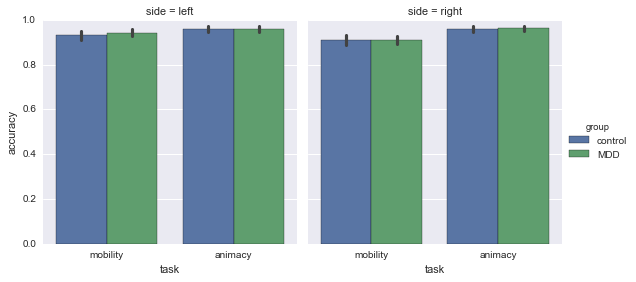

In [14]:
sns.factorplot(y='accuracy',x='task',hue='group',col='side',units='subject',ci=68,kind='bar',data=erp_enc)
sns.plt.savefig(path2figs + 'Enc_acc.pdf')

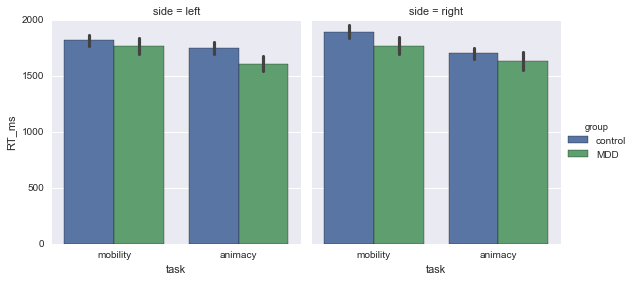

In [15]:
# RT
sns.factorplot(y='RT_ms',x='task',hue='group',col='side',units='subject',ci=68,kind='bar',data=erp_enc)

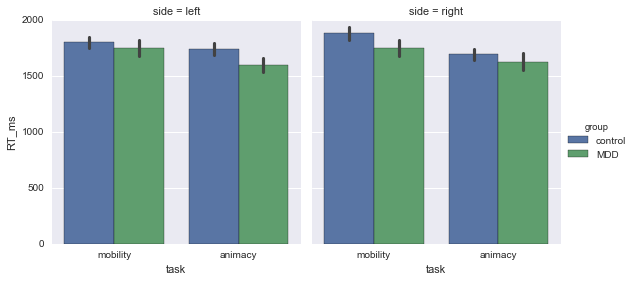

In [16]:
# Accuracy is so high that limiting RT to correct responses probably won't make much difference, but let's check.
# Nope, not much different . . . 
sns.factorplot(y='RT_ms',x='task',hue='group',col='side',units='subject',ci=68,kind='bar',
               data=erp_enc[erp_enc.accuracy == 1])
sns.plt.savefig(path2figs + 'Enc_corr_RT.pdf')

In [17]:
# ANOVA on encoding accuracy; only effect is Task

%Rpush erp_enc
# %R str(erp_enc)

%R enc_acc.aov <- aov_ez(id='subject', dv='accuracy', within=c('task','side'), between='group', data=erp_enc)
%R print(enc_acc.aov)

/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: accuracy
           Effect    df  MSE         F    ges p.value
1           group 1, 46 0.01      0.05  .0006     .82
2            task 1, 46 0.00 13.03 ***    .07   .0008
3      group:task 1, 46 0.00      0.08  .0005     .78
4            side 1, 46 0.00    3.83 +   .008     .06
5      group:side 1, 46 0.00      0.02 <.0001     .88
6       task:side 1, 46 0.00    3.72 +    .01     .06
7 group:task:side 1, 46 0.00      0.22  .0006     .64

Sphericity correction method: GG 


In [18]:
# Give me the descriptives by task
g = erp_enc.groupby(['subject','task'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
print 100*(df.groupby('task')['accuracy'].mean())
print 100*(df.groupby('task')['accuracy'].std())

task
animacy     95.905470
mobility    92.377485
Name: accuracy, dtype: float64
task
animacy     4.722823
mobility    6.212993
Name: accuracy, dtype: float64


In [19]:
# To compute effect size with Cohen's d using R, need to aggregate w/in subs first
g = erp_enc.groupby(['subject','task'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
print df.groupby('task')['accuracy'].mean()
print df.groupby('task')['accuracy'].std()
# sp.stats.pearsonr(df[df.task == 'mobile_immobile']['accuracy'],df[df.task == 'living_non-living']['accuracy'])
df.head()

%Rpush df
%R str(df)
%R enc_acc.es <- cohen.d(accuracy ~ task, data=df, paired=TRUE)
%R print(enc_acc.es)

task
animacy     0.959055
mobility    0.923775
Name: accuracy, dtype: float64
task
animacy     0.047228
mobility    0.062130
Name: accuracy, dtype: float64


'data.frame':	96 obs. of  3 variables:
 $ subject : Factor w/ 48 levels "SM011","SM013",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ task    : Factor w/ 2 levels "animacy","mobility": 1 2 1 2 1 2 1 2 1 2 ...
 $ accuracy: num  0.872 0.896 0.936 0.841 0.979 ...



Cohen's d

d estimate: 0.4757381 (small)
95 percent confidence interval:
       inf        sup 
0.06028103 0.89119516 


In [20]:
# ANOVA on encoding RT (correct trials only, as in IGD & AW, 2005). This gives an effect of Task and a 
# Group x Task x Side interaction.

erp_enc_corr = erp_enc[erp_enc.accuracy == 1]
erp_enc_corr = erp_enc_corr[~((erp_enc_corr.subject == 'SM045') | (erp_enc_corr.subject == 'SM046'))]

%Rpush erp_enc_corr

%R enc_rt.aov <- aov_ez(id='subject', dv='RT', within=c('task','side'), between='group',data=erp_enc_corr)
%R print(enc_rt.aov)

Anova Table (Type 3 tests)

Response: RT
           Effect    df  MSE         F    ges p.value
1           group 1, 44 0.33      1.43    .03     .24
2            task 1, 44 0.02 50.20 ***    .05  <.0001
3      group:task 1, 44 0.02      0.12  .0001     .73
4            side 1, 44 0.01      1.54  .0009     .22
5      group:side 1, 44 0.01      0.05 <.0001     .82
6       task:side 1, 44 0.01      2.63   .002     .11
7 group:task:side 1, 44 0.01   8.02 **   .005    .007

Sphericity correction method: GG 


In [21]:
# Compute effect size for RT, again aggregating w/in subs first
g = erp_enc_corr.groupby(['subject','task'])['RT'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
print 1000*(df.groupby('task')['RT'].mean())
print 1000*(df.groupby('task')['RT'].std())
df.head()

%Rpush df
%R str(df)
%R enc_rt.es <- cohen.d(RT ~ task, data=df, paired=T)
%R print(enc_rt.es)

task
animacy     1668.573484
mobility    1804.380359
Name: RT, dtype: float64
task
animacy     292.269578
mobility    297.769705
Name: RT, dtype: float64


'data.frame':	92 obs. of  3 variables:
 $ subject: Factor w/ 46 levels "SM011","SM013",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ task   : Factor w/ 2 levels "animacy","mobility": 1 2 1 2 1 2 1 2 1 2 ...
 $ RT     : num  1.39 1.59 1.76 2.09 1.78 ...



Cohen's d

d estimate: -0.2914216 (small)
95 percent confidence interval:
       inf        sup 
-0.7125157  0.1296726 


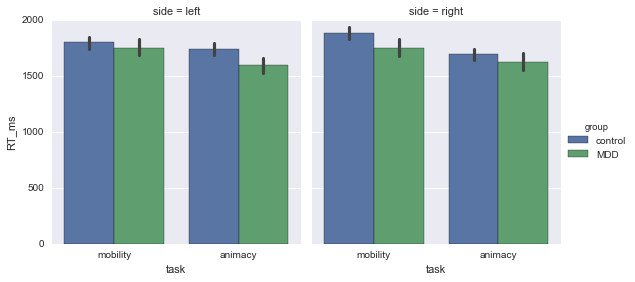

In [22]:
# Interaction seems to reflect a bigger group difference in RT for animacy on left side vs. mobility on right,
# but the GxT is not significant under either side considered separately, see below.

sns.factorplot(y='RT_ms',x='task',hue='group',col='side',units='subject',ci=68,kind='bar',data=erp_enc_corr)

In [23]:
# Okay, so let's look for Group x Task at each level of Side. Left first; no Group x Task here.

left = erp_enc_corr[erp_enc_corr.side == 'left']

%Rpush left

%R left_rt.aov <- aov_ez(id='subject',dv='RT', within='task', between='group', data=left)
%R print(left_rt.aov)

Anova Table (Type 3 tests)

Response: RT
      Effect    df  MSE         F  ges p.value
1      group 1, 44 0.15      1.46  .03     .23
2       task 1, 44 0.01 21.54 ***  .04  <.0001
3 group:task 1, 44 0.01    3.75 + .007     .06

Sphericity correction method: GG 


In [24]:
# Now right . . . no significant Group x Task here either.

right = erp_enc_corr[erp_enc_corr.side == 'right']

%Rpush right

%R right_rt.aov <- aov_ez(id='subject',dv='RT', within='task', between='group', data=right)
%R print(right_rt.aov)

Anova Table (Type 3 tests)

Response: RT
      Effect    df  MSE         F  ges p.value
1      group 1, 44 0.19      1.34  .03     .25
2       task 1, 44 0.01 45.74 ***  .06  <.0001
3 group:task 1, 44 0.01      2.07 .003     .16

Sphericity correction method: GG 


**Summary:** at encoding, everyone is slower and less accurate for mobility vs. animacy judgments. There are no reliable group differences, but if anything, the MDD group is a little quicker.

## Retrieval

In [25]:
# Response options:
# 'Question': 1 = sure living/non-living, 2 = prob living/non-living, 4 = prob mobile/immobile, 5 = sure mob/immob
# 'Side': 1 = sure left, 2 = prob left, 4 = prob right, 5 = sure right
# 'Odd_even': 1 = sure odd, 2 = prob odd, 4 = prob even, 5 = sure even
# 3 = guess for all prompts

# Conditions:
# 1 = left/living_non-living
# 2 = right/living_non-living
# 3 = left/mobile_immobile
# 4 = right/mobile_immobile

def CompAcc(trialtype):
    
    prompt, condition, response = trialtype
    
    CondDict = {1 : 'left/living_non-living', 2 : 'right/living_non-living',
                3 : 'left/mobile_immobile', 4 : 'right/mobile_immobile',
                5 : 'odd', 6 : 'even'}
    
    RespDicts = {'Question' : {1 : 'living_non-living', 2 : 'living_non-living', 3 : 'guess',
                                4 : 'mobile_immobile', 5 : 'mobile_immobile', 999 : 'no_response'},
                'Side' : {1 : 'left', 2 : 'left', 3 : 'guess', 4 : 'right', 5 : 'right', 999 : 'no_response'},
                'Odd_even' : {1 : 'odd', 2 : 'odd', 3 : 'guess', 4 : 'even', 5 : 'even', 999 : 'no_response'}}
    
    if response == 1 or response == 5:
        Confidence = 'high'
    elif response == 2 or response == 4:
        Confidence = 'low'
    elif response == 3 or response == 999:
        Accuracy = np.nan
        Confidence = np.nan 
        
    CurrCond = CondDict[condition]
    CurrResp = RespDicts[prompt][response]
    
    if '/' in CurrCond:
        ActualSide = CurrCond.split('/')[0]
        ActualTask = CurrCond.split('/')[1]
    
    else:
        Parity = CurrCond
          
    if CurrResp != 'guess' and CurrResp != 'no_response':
        if prompt == 'Odd_even':
            if Parity == CurrResp:
                Accuracy = 1
            elif Parity != CurrResp:
                Accuracy = 0
    
        elif prompt == 'Question' and ActualTask == CurrResp:
            Accuracy = 1

        elif prompt == 'Question' and ActualTask != CurrResp:
            Accuracy = 0

        elif prompt == 'Side' and ActualSide == CurrResp:
            Accuracy = 1

        elif prompt == 'Side' and ActualSide != CurrResp:
            Accuracy = 0

    return (Accuracy,Confidence)

In [26]:
# Assemble the retrieval dataframe.
%cd {path2data}
# subjects = !ls -d SM0*

r_dfs = []
rf_d = re.compile('Source_ret')

for subject in erpSubs_all:
    curr_path = path2data + subject
    for root, dirs, files in os.walk(curr_path):
        for filename in files:
            rf_m = rf_d.search(filename)
            if rf_m:
                file_path = curr_path + '/CSV/' + filename
                r_df = pd.read_csv(file_path)
                r_df['subject'] = subject
                r_dfs.append(r_df)
                
ret_data = pd.concat(r_dfs)
ret_data.RT = ret_data.RT.map(lambda x: np.nan if x <0 else x) # set RT to np.nan for 45 and 46
ret_data['RT_ms'] = ret_data.RT.map(lambda x: np.nan if x == 999.0 else x*1000)
ret_data['lnRT'] = ret_data.RT_ms.map(lambda x: np.nan if x == np.nan else np.log(x))

# Code accuracy
ret_data['accuracy'], ret_data['confidence'] = zip(*ret_data[['prompt','condition','response']].apply(CompAcc, axis=1))

# Mark and drop outliers (mean +/- 3SDs for log RT) and trials with no response
dfs = []
for sub in ret_data.subject.unique():
    outliers = []
    sdf = ret_data[ret_data.subject == sub]
    
    mean = sdf.lnRT.mean()
    std = sdf.lnRT.std()
    low = mean-3*std
    high = mean+3*std
    
    for i, row_i in sdf.iterrows():
        if pd.isnull(row_i.lnRT):
            outliers.append(np.nan)
        elif row_i.lnRT < low or row_i.lnRT > high:
            outliers.append(1)
        else:
            outliers.append(0)
    
    sdf['outlier'] = outliers
    if sub == 'SM045' or sub == 'SM046': # For these subjects, all RT/RT_ms/lnRT == np.nan. Leave in . . 
        dfs.append(sdf)
    else:
        sdf_clean = sdf.dropna(subset=['outlier']) # First drop trials with no response
        sdf_clean = sdf_clean[~(sdf_clean.outlier == 1)] # Next drop trials with outliers on lnRT
        dfs.append(sdf_clean)

ret_clean = pd.concat(dfs)
ret_clean.reset_index(inplace=True,drop=True)

ret_clean.to_csv(path2analysis + 'ret_clean.csv',index=False)

# What percentage of trials was dropped? This is higher than originally reported b/c before I only counted
# number of outliers and did not include the trials w/no response that were dropped.
all_trials = float(len(ret_data))
clean_trials = len(ret_clean)
difference = float(all_trials - clean_trials)
print "{:.2f}".format(100*(difference/all_trials))

/Users/danieldillon/Work/Expts/SOURCE/Data
0.24


/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
# Merge the retrieval and self-report data
ret = pd.merge(ret_clean,sr,on='subject')
ret = ret[~(ret.Inclusion == 0)] # Drop subjects who should be excluded based on MINI

# Fix dtype issues
del ret['Notes']
ret.Group = ret.Group.astype(int)
ret.Gender = ret.Gender.astype(str)
ret.Race = ret.Race.astype(str)
ret['Highest Degree'] = ret['Highest Degree'].astype(str)
ret.Occupation = ret.Occupation.astype(str)
ret.Income = ret.Income.astype(str)
ret.Inclusion = ret.Inclusion.astype(int)
ret.confidence = ret.confidence.astype(str)

# Rename a couple things
ret.rename(columns={'Group':'group','Gender':'gender','prompt':'cue'},inplace=True)

# Add guesses
ret['guess'] = ret.response.map(lambda x: 1 if x == 3 else 0)

# Go with group names rather than numbers
ret.group = ret.group.replace(to_replace={0:'control',1:'MDD'})

# And grab just those subjects with clean ERP data
erp_ret = ret[ret.subject.isin(erpSubs_all)]

In [28]:
# We need to know which words were encoded on the left vs. right and with what question. 
# This information is contained in "condition" but let's make columns with more obvious names.

def EncodingCondition(value):

    CondDict = {1 : 'left/living_non-living', 2 : 'right/living_non-living',
                3 : 'left/mobile_immobile', 4 : 'right/mobile_immobile'}
    
    if value == 5 or value == 6: # These are odd/even trials
        side = 'none'
        question = 'none'
    else:
        condition = CondDict[value]
        side = condition.split('/')[0]
        question = condition.split('/')[1]
        if question == 'living_non-living':
            question = 'animacy'
        elif question == 'mobile_immobile':
            question = 'mobility'
    
    return (side, question)

erp_ret['encoding_location'],erp_ret['encoding_task'] = zip(*erp_ret.condition.map(EncodingCondition))

In [29]:
erp_ret.groupby('group')['subject'].nunique()

group
MDD        24
control    24
Name: subject, dtype: int64

### Guesses 

IGD pointed to the guesses and wants to know if there are group differences there. Let's look at that again here. Guesses were response 3, which yielded accuracy = 999.

In [30]:
# First, let's see how many people there are with no guesses. We can do that by subtracting out the number of people
# with guesses . . . 
guess = erp_ret[erp_ret.response == 3]
g = guess.groupby(['subject','group','cue','encoding_task'])['response'].value_counts()
df = g.to_frame()
df.reset_index(inplace=True)
cols = ['subject','group','cue','encoding_task','response','count']
df.columns = cols
df = df[['subject','group','cue','encoding_task','count']]
df.head() # This df holds the data from everyone who guessed at least once

,subject,group,cue,encoding_task,count
0,SM011,control,Question,mobility,1
1,SM011,control,Side,mobility,1
2,SM013,control,Question,animacy,5
3,SM013,control,Question,mobility,2
4,SM013,control,Side,animacy,5


In [31]:
# Shows that there were a lot of guesses on Side trials, many fewer on Question trials, and only 1 O/E guess . . .
print df.cue.unique()

s_guess = 0
q_guess = 0
n_guess = 0

for i, row_i in erp_ret.iterrows():
    if row_i.response == 3 and row_i.cue == 'Side':
        s_guess = s_guess + 1
    elif row_i.response == 3 and row_i.cue == 'Question':
        q_guess = q_guess + 1
    elif row_i.response == 3 and row_i.cue == 'Odd_even':
        n_guess = n_guess + 1

print 'The number of Side guesses = ' + str(s_guess)
print 'The number of Question guesses = ' + str(q_guess)
print 'The number of Odd/Even guesses = ' + str(n_guess)

['Question' 'Side' 'Odd_even']
The number of Side guesses = 536
The number of Question guesses = 387
The number of Odd/Even guesses = 1


In [32]:
# The only subject to guess on an Odd/Even trial was subject SM041, who did so on trial 32 of run 1
s41 = erp_ret[erp_ret.subject == 'SM041']
for i, row_i in s41.iterrows():
    if row_i.cue == 'Odd_even' and row_i.response == 3:
        print row_i

subject                          SM041
run                                  1
trial                               32
cue                           Odd_even
item                               one
condition                            5
response                             3
RT                               3.518
iti_dur(ms)                       2004
RT_ms                             3518
lnRT                           8.16565
accuracy                           NaN
confidence                         nan
outlier                              0
group                          control
Age                                 27
gender                               m
Race                                 5
Ethnicity                            0
Marital_Status           never married
Education_Level      four year college
Education_Years                     22
Occupation                 PHD student
Highest Degree                      BA
Income                          25-50K
Inclusion                

In [33]:
# Okay, since the df above only holds data for people who've guessed, let's use that to figure out who never guessed.
# Since there are 24 people per group, this implies that 3 controls and 2 MDDs never guessed.
df.groupby('group')['subject'].nunique()

group
MDD        22
control    21
Name: subject, dtype: int64

In [34]:
# For the ANOVA, we're going to need a df that includes only subjects who guessed at least once for each task and cue.
# Also, get a count of subjects who did not guess in at least one of the four conditions defined by (Cue x Task).
# Because there was only one Odd/Even guess, I'm dropping that condition first.

df = df[~(df.cue == 'Odd_even')]

mdd_ct = 0
hc_ct = 0
no_guesses = []

for sub in df.subject.unique():
    num = int(df[df.subject == sub]['subject'].value_counts())
    if num != 4: # There are 4 conditions (2 Cues x 2 Task) and we're looking for people who don't have all 4
        sdf = df[df.subject == sub]
        sdf.reset_index(inplace=True,drop=True)
        group = sdf.group.ix[0]
        if group == 'control':
            hc_ct = hc_ct + 1
        elif group == 'MDD':
            mdd_ct = mdd_ct + 1
        no_guesses.append(sub)
print "There are " + str(hc_ct) + " controls and " + str(mdd_ct) + " depressed adults who did not guess in response \
to the Question or the Side cue, or both."

nog = df[df['subject'].isin(no_guesses)]
nog['count'].describe() # Shows that the people who did not guess in at least one condition did not guess much overall.

There are 8 controls and 4 depressed adults who did not guess in response to the Question or the Side cue, or both.


count    30.000000
mean      3.100000
std       3.111159
min       1.000000
25%       1.000000
50%       2.000000
75%       3.750000
max      13.000000
Name: count, dtype: float64

Putting together the 3 controls who never guessed and the 8 controls who did not guess in at least 1 condition, we have 13 controls with guesses in all 4 conditions (Cue x Task). For the MDDs, there were 2 who never guessed and 4 who did not guess in at least 1 condition, which leaves 18 who guessed at least once in all 4 conditions. So we're going to be graphing and running ANOVAs on guess data from HC = 13 and MDD = 18. SM041 is still in b/c he/she guessed on trials besides that one Odd/Even trial.

In [35]:
df.head()

,subject,group,cue,encoding_task,count
0,SM011,control,Question,mobility,1
1,SM011,control,Side,mobility,1
2,SM013,control,Question,animacy,5
3,SM013,control,Question,mobility,2
4,SM013,control,Side,animacy,5


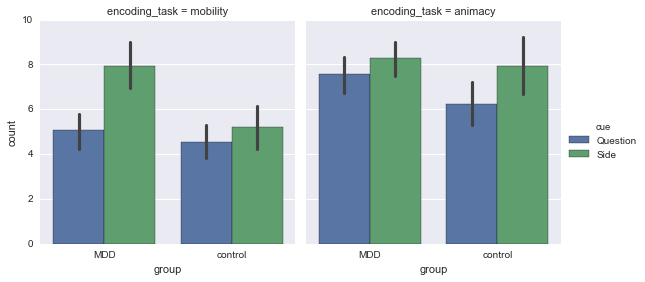

In [36]:
# Now plot the guess data, excluding the subjects with no guesses in one more more condition
# So looks like the MDDs guess more, everybody guesses more under Side vs. Question. Notice that MDDs guess 
# least for Q/MI.

df = df[~(df['subject'].isin(no_guesses))]
sns.factorplot(y='count',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',data=df,
              order = ['MDD','control'], col_order=['mobility','animacy'])
sns.plt.savefig(path2figs + 'Guessing_GxCxT.pdf')

In [37]:
# Let's get the descriptives there in case we want to use a table instead of a graph
print df.groupby(['group','cue','encoding_task'])['count'].mean()
print df.groupby(['group','cue','encoding_task'])['count'].std()

group    cue       encoding_task
MDD      Question  animacy          7.555556
                   mobility         5.055556
         Side      animacy          8.277778
                   mobility         7.944444
control  Question  animacy          6.230769
                   mobility         4.538462
         Side      animacy          7.923077
                   mobility         5.230769
Name: count, dtype: float64
group    cue       encoding_task
MDD      Question  animacy          3.518392
                   mobility         3.455128
         Side      animacy          3.409426
                   mobility         4.465189
control  Question  animacy          3.677722
                   mobility         2.817072
         Side      animacy          4.609077
                   mobility         3.811252
Name: count, dtype: float64


In [38]:
# ANOVA on guesses; effects of Cue and Task, people guessed more in to Side vs. Question and for Animacy vs. Mobility.
# No effect of Group, no interactions.

%Rpush df
# %R str(df)

%R guess.aov <- aov_ez(id='subject',dv='count', within=c('cue','encoding_task'), between='group', data=df)
%R print(guess.aov)

Anova Table (Type 3 tests)

Response: count
                   Effect    df   MSE         F  ges p.value
1                   group 1, 29 36.31      1.25  .03     .27
2                     cue 1, 29  8.75   7.75 **  .04    .009
3               group:cue 1, 29  8.75      0.32 .002     .57
4           encoding_task 1, 29  6.15 15.98 ***  .06   .0004
5     group:encoding_task 1, 29  6.15      0.74 .003     .40
6       cue:encoding_task 1, 29  5.23      0.49 .002     .49
7 group:cue:encoding_task 1, 29  5.23    3.62 +  .01     .07

Sphericity correction method: GG 


In [39]:
# Give me descriptives for the main effect of Cue
print df.groupby('cue')['count'].mean()
print df.groupby('cue')['count'].std()

cue
Question    5.919355
Side        7.467742
Name: count, dtype: float64
cue
Question    3.526473
Side        4.147754
Name: count, dtype: float64


In [40]:
# Now descriptives for the main effect of Task
print df.groupby('encoding_task')['count'].mean()
print df.groupby('encoding_task')['count'].std()

encoding_task
animacy     7.564516
mobility    5.822581
Name: count, dtype: float64
encoding_task
animacy     3.753123
mobility    3.902602
Name: count, dtype: float64


In [41]:
df.head()

,subject,group,cue,encoding_task,count
2,SM013,control,Question,animacy,5
3,SM013,control,Question,mobility,2
4,SM013,control,Side,animacy,5
5,SM013,control,Side,mobility,6
6,SM014,control,Question,animacy,1


In [42]:
# I bet there are fewer Q vs. S guesses for MI words in MDDs but no other within wordtype cue effects.
# Yup.
misc.ttest_2s(df[(df.group == 'MDD') & (df.encoding_task == 'mobility') & (df.cue == 'Question')]['count'],
              df[(df.group == 'MDD') & (df.encoding_task == 'mobility') & (df.cue == 'Side')]['count'],
              paired=True)

misc.ttest_2s(df[(df.group == 'MDD') & (df.encoding_task == 'animacy') & (df.cue == 'Question')]['count'],
              df[(df.group == 'MDD') & (df.encoding_task == 'animacy') & (df.cue == 'Side')]['count'],
              paired=True)

# No effect of cue on the tasks considered separately in controls
misc.ttest_2s(df[(df.group == 'control') & (df.encoding_task == 'mobility') & (df.cue == 'Question')]['count'],
              df[(df.group == 'control') & (df.encoding_task == 'mobility') & (df.cue == 'Side')]['count'],
              paired=True)

misc.ttest_2s(df[(df.group == 'control') & (df.encoding_task == 'animacy') & (df.cue == 'Question')]['count'],
              df[(df.group == 'control') & (df.encoding_task == 'animacy') & (df.cue == 'Side')]['count'],
              paired=True)

# Check to see if the guessing rate for Q/MI words is lower than for all other cells of the design for MDDs
misc.ttest_2s(df[(df.group == 'MDD') & (df.encoding_task == 'mobility') & (df.cue == 'Question')]['count'],
              df[(df.group == 'MDD') & (df.encoding_task == 'animacy') & (df.cue == 'Question')]['count'],
              paired=True)

misc.ttest_2s(df[(df.group == 'MDD') & (df.encoding_task == 'mobility') & (df.cue == 'Question')]['count'],
              df[(df.group == 'MDD') & (df.encoding_task == 'animacy') & (df.cue == 'Side')]['count'],
              paired=True)

# all this shows that MDDs guessed less in Q/MI than in any other cell.

t(17) = -3.29, p = 0.004
t(17) = -0.87, p = 0.397
t(12) = -0.83, p = 0.423
t(12) = -1.32, p = 0.210
t(17) = -3.74, p = 0.002
t(17) = -3.59, p = 0.002


(-3.5856679138605703, 0.0022786918690245353)

In [43]:
# Compute effect sizes for the guessing comparisons in the MDD group as they are significant
mdd_guess = df[df.group == 'MDD']

%Rpush mdd_guess
%R str(mdd_guess)
%R QMI_v_SMI.es <- cohen.d(count ~ cue, data=subset(mdd_guess, encoding_task=='mobility'), paired=TRUE)
%R QMI_v_QLNL.es <- cohen.d(count ~ encoding_task, data=subset(mdd_guess, cue=='Question'), paired=TRUE)
%R QMI <- subset(mdd_guess, encoding_task=='mobility' & cue=='Question')
%R SLNL <- subset(mdd_guess, encoding_task=='animacy' & cue=='Side')
%R QMI_v_SLNL.es <- cohen.d(QMI$count, SLNL$count, paired=TRUE)

%R print(QMI_v_SMI.es)
%R print(QMI_v_QLNL.es)
%R print(QMI_v_SLNL.es)

'data.frame':	72 obs. of  5 variables:
 $ subject      : Factor w/ 18 levels "SM026","SM031",..: 1 1 1 1 2 2 2 2 3 3 ...
 $ group        : Factor w/ 1 level "MDD": 1 1 1 1 1 1 1 1 1 1 ...
 $ cue          : Factor w/ 2 levels "Question","Side": 1 1 2 2 1 1 2 2 1 1 ...
 $ encoding_task: Factor w/ 2 levels "animacy","mobility": 1 2 1 2 1 2 1 2 1 2 ...
 $ count        : int  3 1 8 2 6 5 5 3 6 4 ...



Cohen's d

d estimate: -0.7656806 (medium)
95 percent confidence interval:
        inf         sup 
-1.48927313 -0.04208797 



Cohen's d

d estimate: 0.8176017 (large)
95 percent confidence interval:
       inf        sup 
0.09036535 1.54483808 



Cohen's d

d estimate: -0.84515 (large)
95 percent confidence interval:
       inf        sup 
-1.5744089 -0.1158912 


So the **bottom line for guesses** is that everyone guessed more in response to Side versus Question cue and in response to words from the animacy vs. mobility task, and the combination of Question/mobility led to especially few guesses in MDD.

### Accuracy 

#### Odd/Even 

We are ultimately going to want to run Group x Cue x Task, and since there is no Task when Cue == Odd_even, we're going to have to drop the Odd/Even trials from the analysis. But first let's look at the accuracy data from those trials, to see whether there are any group differences.

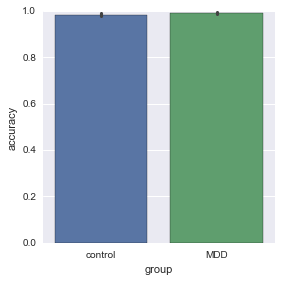

In [44]:
# Shows that both groups are extremely accurate on Odd/Even trials 
oe = erp_ret[erp_ret.cue == 'Odd_even']
sns.factorplot(y='accuracy',x='group',units='subject',ci=68,kind='bar',data=oe)

In [45]:
# T-test on the group difference in accuracy on Odd/Even trials, no difference.
g = oe.groupby(['group','subject'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
print 100*(df.groupby('group')['accuracy'].mean())
print 100*(df.groupby('group')['accuracy'].std())
misc.ttest_2s(df[df.group == 'control']['accuracy'],df[df.group == 'MDD']['accuracy'])

group
MDD        99.129660
control    98.436586
Name: accuracy, dtype: float64
group
MDD        1.365453
control    3.921568
Name: accuracy, dtype: float64
t(46) = -0.82, p = 0.418


(-0.8176674629163585, 0.41776234752428887)

#### Group x Cue x Task 

Okay, for the rest of the accuracy analysis we want to exclude the Odd/Even trials. So let's set up a df without those.

In [46]:
noe = erp_ret[~(erp_ret.cue == 'Odd_even')]
noe.reset_index(inplace = True,drop=True)
noe.head()

,subject,run,trial,cue,item,condition,response,RT,iti_dur(ms),RT_ms,...,PSQI_DayDys,PSQI_Efficiency,PSQI_Quality,PSQI_Medication,PSQI_Total,WTAR_NatEng,WTAR_StdScore,guess,encoding_location,encoding_task
0,SM011,1,1,Question,cabin,3,1,4.669,1002,4669,...,0,0,0,0,1,yes,89,0,left,mobility
1,SM011,1,2,Question,desk,4,1,3.201,501,3201,...,0,0,0,0,1,yes,89,0,right,mobility
2,SM011,1,3,Question,fern,1,1,0.784,501,784,...,0,0,0,0,1,yes,89,0,left,animacy
3,SM011,1,5,Question,balloon,2,1,1.067,1002,1067,...,0,0,0,0,1,yes,89,0,right,animacy
4,SM011,1,7,Question,pine,4,1,0.567,2004,567,...,0,0,0,0,1,yes,89,0,right,mobility


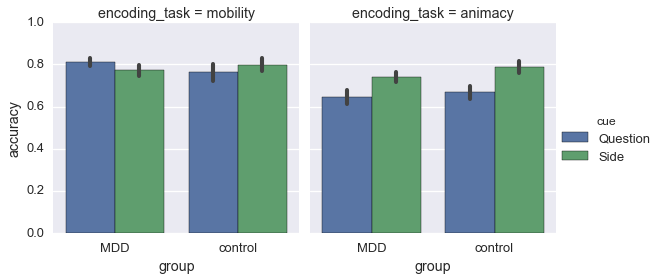

In [47]:
# I think this is a good way to plot the data b/c it highlights the group difference in the cue effect for words from
# the mobility task. 
sns.set_style('darkgrid')
sns.set_context('talk')
sns.factorplot(y='accuracy',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',data=noe,
              order = ['MDD','control'])
sns.plt.ylim(0,1,0.2)
sns.plt.savefig(path2figs + 'Ret_Acc_GxCxT.pdf')

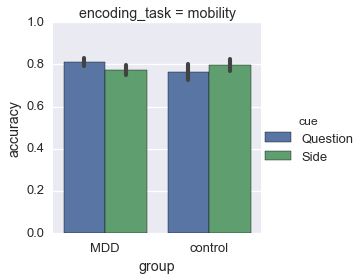

In [48]:
# Plotting the mobility data alone just to make it easier to line up with Q-S difference score plot
sns.set_style('darkgrid')
sns.set_context('talk')
sns.factorplot(y='accuracy',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',
               data=noe[noe.encoding_task == 'mobility'], order = ['MDD','control'])
sns.plt.ylim(0,1,0.2)
sns.plt.savefig(path2figs + 'Ret_Acc_GxC_MI.pdf')

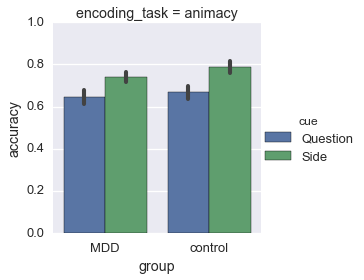

In [49]:
# Plotting the animacy data alone just to make it easier to line up with Q-S difference score plot
sns.factorplot(y='accuracy',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',
               data=noe[noe.encoding_task == 'animacy'], order = ['MDD','control'])
sns.plt.ylim(0,1.0,0.2)
sns.plt.savefig(path2figs + 'Ret_Acc_GxC_LNL.pdf')

In [50]:
# For guesses, response == 3 and accuracy == NaN. 
# We don't want to analyze those trials so let's drop.
# End up with effects of Cue and Task, plus Group x Cue and Cue x Task interactions. 
# Initially I followed up the interactions, but I think I would recommend going straight to the Group x Cue ANOVAs,
# separately by task. Or you could start with that--rather than Group x Cue x Task, you could do two Group x Cues.
# That might be too cheesy and it'd mean all the other ANOVAs would have to be done that way too . . . 

noe_nog = noe[~(noe.response == 3)]
%Rpush noe_nog
# %R str(noe)

%R ret_acc <- aov_ez(id='subject',dv='accuracy', within=c('cue','encoding_task'), between='group', data=noe_nog)
%R print(ret_acc)

Anova Table (Type 3 tests)

Response: accuracy
                   Effect    df  MSE         F  ges p.value
1                   group 1, 46 0.05      0.13 .002     .72
2                     cue 1, 46 0.01 20.33 ***  .04  <.0001
3               group:cue 1, 46 0.01    5.49 *  .01     .02
4           encoding_task 1, 46 0.01 30.43 ***  .08  <.0001
5     group:encoding_task 1, 46 0.01      2.55 .007     .12
6       cue:encoding_task 1, 46 0.01 21.69 ***  .04  <.0001
7 group:cue:encoding_task 1, 46 0.01      0.77 .002     .39

Sphericity correction method: GG 


In [51]:
# To follow-up the Group x Cue, we can just run b/w group t-tests at each level of Cue.
# Neither one is significant, but looking at the t values you can see why there is an interaction: 
# it's MDD > HC under Question but MDD < HC under Side.

g = noe_nog.groupby(['subject','group','cue'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)

print 'Group difference under Question:'
misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['accuracy'],
              df[(df.group == 'MDD') & (df.cue == 'Question')]['accuracy'])
print '\nGroup difference under Side:'
misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Side')]['accuracy'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['accuracy'])

Group difference under Question:
t(46) = -0.48, p = 0.631

Group difference under Side:
t(46) = 1.15, p = 0.257


(1.1484021550345016, 0.2567395788133357)

In [52]:
# Here are the descriptives . . the group differences are pretty modest . . . 
print 100*(df.groupby(['group','cue'])['accuracy'].mean())
print '\n'
print 100*(df.groupby(['group','cue'])['accuracy'].std())

group    cue     
MDD      Question    73.225156
         Side        75.567941
control  Question    71.615558
         Side        79.396475
Name: accuracy, dtype: float64


group    cue     
MDD      Question     9.381507
         Side         9.777096
control  Question    13.319982
         Side        13.082374
Name: accuracy, dtype: float64


In [53]:
# To follow-up the Cue x Task, we can collapse over group and run b/w Task comparisons under each Cue.
# No surprise here, big Task effect (mobility > animacy) under Question but not Side . . .

g = noe_nog.groupby(['subject','cue','encoding_task'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

print 'Task difference under Question:'
misc.ttest_2s(df[(df.encoding_task == 'mobility') & (df.cue == 'Question')]['accuracy'],
              df[(df.encoding_task == 'animacy') & (df.cue == 'Question')]['accuracy'],
              paired=True)
print '\nTask difference under Side:'
misc.ttest_2s(df[(df.encoding_task == 'mobility') & (df.cue == 'Side')]['accuracy'],
              df[(df.encoding_task == 'animacy') & (df.cue == 'Side')]['accuracy'],
              paired=True)

Task difference under Question:
t(47) = 5.56, p = 0.000

Task difference under Side:
t(47) = 1.89, p = 0.064


(1.8942861225743457, 0.064349667070553854)

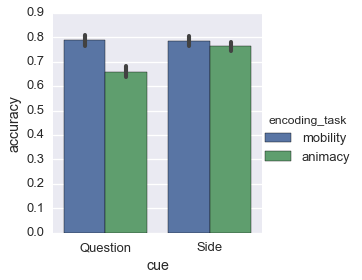

In [54]:
sns.factorplot(y='accuracy',x='cue',hue='encoding_task',units='subject',ci=68,kind='bar',data=noe_nog)

In [55]:
# The other way to follow-up the Cue x Task is to collapse over group and run b/w Cue comparisons for each Task.
# As with the second method of plotting the accuracy data, this is probably better b/c done this way you have the 
# Cue effect when the words/task are being held constant (cleaner look at the retrieval effects).

# And what you find is a big Cue effect for words from the animacy task, no effect at all for words from mobility.

g = noe_nog.groupby(['subject','cue','encoding_task'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

print 'Cue effect for words from the mobility task:'
misc.ttest_2s(df[(df.encoding_task == 'mobility') & (df.cue == 'Question')]['accuracy'],
              df[(df.encoding_task == 'mobility') & (df.cue == 'Side')]['accuracy'],
              paired=True)
print '\nCue effect for words from the animacy task:'
misc.ttest_2s(df[(df.encoding_task == 'animacy') & (df.cue == 'Question')]['accuracy'],
              df[(df.encoding_task == 'animacy') & (df.cue == 'Side')]['accuracy'],
              paired=True)

Cue effect for words from the mobility task:
t(47) = 0.25, p = 0.803

Cue effect for words from the animacy task:
t(47) = -6.08, p = 0.000


(-6.0768563033923337, 2.059059430513222e-07)

Of course the stinker here is there is no 3-way interaction. What if you look for Group x Cue only under for words from mobility?

In [56]:
# If you look only at data from the mobility task, you get a Group x Cue interaction, F = 5.92, p = 0.02.
# No Cue effect here, F < 1.

noe_nog_MI = noe_nog[noe_nog.encoding_task == 'mobility']
%Rpush noe_nog_MI

%R ret_acc_MI <- aov_ez(id='subject',dv='accuracy', within='cue', between='group', data=noe_nog_MI)
%R print(ret_acc_MI)

Anova Table (Type 3 tests)

Response: accuracy
     Effect    df  MSE      F   ges p.value
1     group 1, 46 0.03   0.09  .002     .76
2       cue 1, 46 0.01   0.07 .0002     .79
3 group:cue 1, 46 0.01 5.92 *   .02     .02

Sphericity correction method: GG 


In [57]:
# Make sure you don't get Group x Cue for animacy. No, F < 1; just a strong Cue effect (F > 35).
noe_nog_LNL = noe_nog[noe_nog.encoding_task == 'animacy']
%Rpush noe_nog_LNL

%R ret_acc_LNL <- aov_ez(id='subject',dv='accuracy', within='cue', between='group', data=noe_nog_LNL)
%R print(ret_acc_LNL)

Anova Table (Type 3 tests)

Response: accuracy
     Effect    df  MSE         F  ges p.value
1     group 1, 46 0.03      0.99  .02     .32
2       cue 1, 46 0.01 36.81 ***  .15  <.0001
3 group:cue 1, 46 0.01      0.86 .004     .36

Sphericity correction method: GG 


In [58]:
# Here are the descriptives. 12% difference b/w tasks under Question, 2% under Side.

print 100*(df.groupby(['cue','encoding_task'])['accuracy'].mean())
print '\n'
print 100*(df.groupby(['cue','encoding_task'])['accuracy'].std())

cue       encoding_task
Question  animacy          65.663725
          mobility         78.880143
Side      animacy          76.436370
          mobility         78.474284
Name: accuracy, dtype: float64


cue       encoding_task
Question  animacy          14.380066
          mobility         13.842296
Side      animacy          11.747075
          mobility         12.578142
Name: accuracy, dtype: float64


In [59]:
# Okay, now compute the Q-S difference scores for mobility
noe_nog_MI.head()
g = noe_nog_MI.groupby(['subject','group','cue'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
table_MI = df.pivot_table(index=['subject','group'],columns='cue',values='accuracy')
table_MI.reset_index(inplace=True)
table_MI['Q-S'] = table_MI['Question'] - table_MI['Side']
table_MI['condition'] = 'mobility'
table_MI = table_MI[['subject','group','condition','Question','Side','Q-S']]
new_cols = ['subject','group','condition','Q_acc','S_acc','QvS_acc']
table_MI.columns = new_cols
table_MI = table_MI.reset_index(drop=True)
table_MI.head()

,subject,group,condition,Q_acc,S_acc,QvS_acc
0,SM011,control,mobility,0.297872,0.425532,-0.127660
1,SM013,control,mobility,0.717391,0.700000,0.017391
2,SM014,control,mobility,0.727273,0.869565,-0.142292
3,SM015,MDD,mobility,0.750000,0.541667,0.208333
4,SM017,control,mobility,0.854167,0.860465,-0.006298


In [60]:
# Give me descriptives and the b/w groups t-test
print 100*(table_MI.groupby('group')['QvS_acc'].mean())
print 100*(table_MI.groupby('group')['QvS_acc'].std())
misc.ttest_2s(table_MI[table_MI.group == 'MDD']['QvS_acc'],
             table_MI[table_MI.group == 'control']['QvS_acc'])

group
MDD        4.152923
control   -3.341205
Name: QvS_acc, dtype: float64
group
MDD        11.494746
control     9.774578
Name: QvS_acc, dtype: float64
t(46) = 2.43, p = 0.019


(2.4331693866252193, 0.018912704371913107)

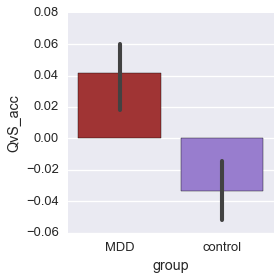

In [61]:
# And plot it . . . 
sns.factorplot(y='QvS_acc',x='group',units='subject',ci=68,kind='bar',data=table_MI,
              order = ['MDD','control'], palette = {'MDD':'FireBrick','control':'MediumPurple'})
sns.plt.ylim(-0.06,0.08,0.02)
sns.plt.savefig(path2figs + 'QvS_MI.pdf')

In [62]:
# Check: are either of these different from zero?
misc.ttest_1s(table_MI[table_MI.group == 'MDD']['QvS_acc'])
misc.ttest_1s(table_MI[table_MI.group == 'control']['QvS_acc'])

t(23) = 1.77, p = 0.090
t(23) = -1.67, p = 0.108


(-1.6745985495194142, 0.10755880904692317)

In [63]:
# Now compute the Q-S difference scores for animacy

g = noe_nog_LNL.groupby(['subject','group','cue'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
table_LNL = df.pivot_table(index=['subject','group'],columns='cue',values='accuracy')
table_LNL.reset_index(inplace=True)
new_cols = ['subject','group','Question','Side']
table_LNL.columns = new_cols
table_LNL['Q-S'] = table_LNL['Question']-table_LNL['Side']
table_LNL['condition'] = 'animacy'
table_LNL = table_LNL[['subject','group','condition','Question','Side','Q-S']]
new_cols = ['subject','group','condition','Q_acc','S_acc','QvS_acc']
table_LNL.columns = new_cols

table_LNL.head()

,subject,group,condition,Q_acc,S_acc,QvS_acc
0,SM011,control,animacy,0.708333,0.437500,0.270833
1,SM013,control,animacy,0.476190,0.790698,-0.314507
2,SM014,control,animacy,0.723404,0.941176,-0.217772
3,SM015,MDD,animacy,0.395833,0.541667,-0.145833
4,SM017,control,animacy,0.659574,0.780488,-0.120913


In [64]:
# Give me descriptives and the b/w groups t-test
print 100*(table_LNL.groupby('group')['QvS_acc'].mean())
print 100*(table_LNL.groupby('group')['QvS_acc'].std())
misc.ttest_2s(table_LNL[table_LNL.group == 'MDD']['QvS_acc'],
             table_LNL[table_LNL.group == 'control']['QvS_acc'])

group
MDD        -9.130522
control   -12.414769
Name: QvS_acc, dtype: float64
group
MDD        10.138071
control    14.136418
Name: QvS_acc, dtype: float64
t(46) = 0.92, p = 0.360


(0.92489712684148884, 0.35984620948864443)

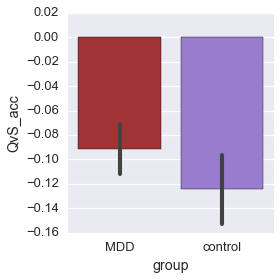

In [65]:
# And plot it . . . 
sns.factorplot(y='QvS_acc',x='group',units='subject',ci=68,kind='bar',data=table_LNL,
              order = ['MDD','control'],palette = {'MDD':'FireBrick','control':'MediumPurple'})
sns.plt.savefig(path2figs + 'QvS_LNL.pdf')

In [66]:
# Check: are either of these animacy difference scores different from zero?
misc.ttest_1s(table_LNL[table_LNL.group == 'MDD']['QvS_acc'])
misc.ttest_1s(table_LNL[table_LNL.group == 'control']['QvS_acc'])

t(23) = -4.41, p = 0.000
t(23) = -4.30, p = 0.000


(-4.3023413801843002, 0.00026502330518159432)

In [67]:
# Need to concat tables for w/in group t-tests
both = pd.concat([table_MI,table_LNL])
both.head()

print 'MDD . . . '
misc.ttest_2s(both[(both.group == 'MDD') & (both.condition == 'mobility')]['QvS_acc'],
             both[(both.group == 'MDD') & (both.condition == 'animacy')]['QvS_acc'],
             paired=True)

print 'controls . . . '
misc.ttest_2s(both[(both.group == 'control') & (both.condition == 'mobility')]['QvS_acc'],
             both[(both.group == 'control') & (both.condition == 'animacy')]['QvS_acc'],
             paired=True)

MDD . . . 
t(23) = 3.75, p = 0.001
controls . . . 
t(23) = 2.80, p = 0.010


(2.7966932630253938, 0.010247585527106305)

In [68]:
both.head()

,subject,group,condition,Q_acc,S_acc,QvS_acc
0,SM011,control,mobility,0.297872,0.425532,-0.127660
1,SM013,control,mobility,0.717391,0.700000,0.017391
2,SM014,control,mobility,0.727273,0.869565,-0.142292
3,SM015,MDD,mobility,0.750000,0.541667,0.208333
4,SM017,control,mobility,0.854167,0.860465,-0.006298


In [69]:
# Compute Cohen's D for the follow-up t-tests on Q-S accuracy
%Rpush both
%R MDD_QSxTask.es <- cohen.d(QvS_acc ~ condition, data=subset(both, group=='MDD'), paired=TRUE)
%R HC_QSxTask.es <- cohen.d(QvS_acc ~ condition, data=subset(both, group=='control'), paired=TRUE)
%R MDD_vs_HC_QS_MI.es <- cohen.d(QvS_acc ~ group, data=subset(both, condition=='mobility'), paired=FALSE)
%R MDD_vs_HC_QS_LNL.es <- cohen.d(QvS_acc ~ group, data=subset(both, condition=='animacy'), paired=FALSE)

%R print(MDD_QSxTask.es)
%R print(HC_QSxTask.es)
%R print(MDD_vs_HC_QS_MI.es)
%R print(MDD_vs_HC_QS_LNL.es)


Cohen's d

d estimate: -0.7662563 (medium)
95 percent confidence interval:
       inf        sup 
-1.3821367 -0.1503758 



Cohen's d

d estimate: -0.5708726 (medium)
95 percent confidence interval:
       inf        sup 
-1.1769276  0.0351824 



Cohen's d

d estimate: -0.7023955 (medium)
95 percent confidence interval:
        inf         sup 
-1.31476678 -0.09002422 



Cohen's d

d estimate: -0.2669948 (small)
95 percent confidence interval:
       inf        sup 
-0.8633185  0.3293289 


In [70]:
# Any chance you get a sig b/w group diff for Q/MI? Nope
misc.ttest_2s(both[(both.group == 'MDD') & (both.condition == 'mobility')]['Q_acc'],
             both[(both.group == 'control') & (both.condition == 'mobility')]['Q_acc'])

t(46) = 1.21, p = 0.232


(1.2117622495260811, 0.23179132239077543)

In [71]:
# Give me descriptives in every cell of the design . . .
g = noe_nog.groupby(['subject','group','encoding_task','cue'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

print 100*df.groupby(['group','encoding_task','cue'])['accuracy'].mean()
print 100*df.groupby(['group','encoding_task','cue'])['accuracy'].std()

group    encoding_task  cue     
MDD      animacy        Question    64.814616
                        Side        73.945138
         mobility       Question    81.289226
                        Side        77.136303
control  animacy        Question    66.512833
                        Side        78.927602
         mobility       Question    76.471060
                        Side        79.812265
Name: accuracy, dtype: float64
group    encoding_task  cue     
MDD      animacy        Question    15.088227
                        Side        10.344191
         mobility       Question     8.406062
                        Side        10.682593
control  animacy        Question    13.906979
                        Side        12.729212
         mobility       Question    17.572002
                        Side        14.333324
Name: accuracy, dtype: float64


In [72]:
# Okay, now compute the Q-S confidence difference scores for mobility (for use in correls with ERPs later)
noe_nog_MI['high_confidence'] = noe_nog_MI.confidence.apply(lambda x: 1 if x == 'high' else 0)
g = noe_nog_MI.groupby(['subject','group','cue'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
table_MI_conf = df.pivot_table(index=['subject','group'],columns='cue',values='high_confidence')
table_MI_conf.reset_index(inplace=True)
table_MI_conf['QvS_conf'] = table_MI_conf['Question'] - table_MI_conf['Side']
table_MI_conf['condition'] = 'mobility'
table_MI_conf = table_MI_conf[['subject','group','condition','Question','Side','QvS_conf']]
new_cols = ['subject','group','condition','Q_conf','S_conf','QvS_conf']
table_MI_conf.columns = new_cols
table_MI_conf = table_MI_conf.reset_index(drop=True)
table_MI_conf.head()

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


,subject,group,condition,Q_conf,S_conf,QvS_conf
0,SM011,control,mobility,0.957447,0.617021,0.340426
1,SM013,control,mobility,0.804348,0.525000,0.279348
2,SM014,control,mobility,0.522727,0.478261,0.044466
3,SM015,MDD,mobility,0.895833,0.562500,0.333333
4,SM017,control,mobility,0.416667,0.302326,0.114341


In [73]:
# Okay, now compute the Q-S confidence difference scores for animacy (for use in correls with ERPs later)
noe_nog_LNL['high_confidence'] = noe_nog_LNL.confidence.apply(lambda x: 1 if x == 'high' else 0)
g = noe_nog_LNL.groupby(['subject','group','cue'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
table_LNL_conf = df.pivot_table(index=['subject','group'],columns='cue',values='high_confidence')
table_LNL_conf.reset_index(inplace=True)
table_LNL_conf['QvS_conf'] = table_LNL_conf['Question'] - table_LNL_conf['Side']
table_LNL_conf['condition'] = 'animacy'
table_LNL_conf = table_LNL_conf[['subject','group','condition','Question','Side','QvS_conf']]
new_cols = ['subject','group','condition','Q_conf','S_conf','QvS_conf']
table_LNL_conf = table_LNL_conf.reset_index(drop=True)
table_LNL_conf.head()

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


cue,subject,group,condition,Question,Side,QvS_conf
0,SM011,control,animacy,1.000000,0.604167,0.395833
1,SM013,control,animacy,0.809524,0.534884,0.274640
2,SM014,control,animacy,0.489362,0.588235,-0.098874
3,SM015,MDD,animacy,0.979167,0.395833,0.583333
4,SM017,control,animacy,0.446809,0.292683,0.154126


In [74]:
# In response to BP Reviewer 1, let's repeat the Group x Cue under mobility with education and WTAR as covs to see
# if they matter. Education does not matter but WTAR is significant and there is a Cue x WTAR interaction that
# renders the Group x Cue effect n.s.

noe_nog_MI_wtar = noe_nog_MI[noe_nog_MI.WTAR_NatEng == 'yes']
%Rpush noe_nog_MI_wtar

%R ret_acc_MI_afex <- aov_ez(id='subject', dv='accuracy', data=noe_nog_MI, between='group', within='cue')

%R ret_acc_MI_educ <- aov_ez(id='subject', dv='accuracy', data=noe_nog_MI, between='group',\
                             within='cue', covariate=c('Education_Years'))

%R ret_acc_MI_wtar <- aov_ez(id='subject', dv='accuracy', data=noe_nog_MI_wtar, between='group',\
                             within='cue',covariate=c('WTAR_StdScore'))

%R print(ret_acc_MI_afex)
%R print(ret_acc_MI_educ)
%R print(ret_acc_MI_wtar)

/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Converting to factor: Education_Years

  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group, Education_Years

  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Converting to factor: WTAR_StdScore

  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group, WTAR_StdScore

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: accuracy
     Effect    df  MSE      F   ges p.value
1     group 1, 46 0.03   0.09  .002     .76
2       cue 1, 46 0.01   0.07 .0002     .79
3 group:cue 1, 46 0.01 5.92 *   .02     .02

Sphericity correction method: GG 


Anova Table (Type 3 tests)

Response: accuracy
               Effect     df  MSE      F  ges p.value
1               group  1, 36 0.03   1.45  .03     .24
2     Education_Years 10, 36 0.03   1.78  .28     .10
3                 cue  1, 36 0.01   0.19 .001     .67
4           group:cue  1, 36 0.01 6.96 *  .04     .01
5 Education_Years:cue 10, 36 0.01   0.40  .02     .94

Sphericity correction method: GG 


Anova Table (Type 3 tests)

Response: accuracy
             Effect     df  MSE       F    ges p.value
1             group  1, 23 0.02    0.67    .02     .42
2     WTAR_StdScore 19, 23 0.02  2.53 *    .64     .02
3               cue  1, 23 0.00    0.06  .0004     .80
4         group:cue  1, 23 0.00    0.01 <.0001     .92
5 WTAR_StdScore:cue 19, 23 0.00 2.90 **    .26    .008

Sphericity correction method: GG 


In [75]:
noe_nog_MI_wtar.WTAR_StdScore.describe()

count    3856.000000
mean      116.800830
std         9.831407
min        89.000000
25%       113.000000
50%       120.000000
75%       124.000000
max       128.000000
Name: WTAR_StdScore, dtype: float64

In [76]:
def MedSplit(wtar):
    '''Based on the descriptive data, I am running a median split on WTAR scores to ease the graphing.'''
    if wtar < 120:
        out = 'low'
    elif wtar > 120:
        out = 'high'
    elif wtar == 120:
        out = np.nan
        
    return out

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


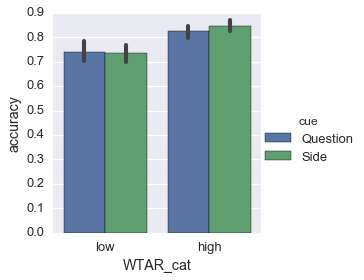

In [77]:
noe_nog_MI_wtar['WTAR_cat'] = noe_nog_MI_wtar.WTAR_StdScore.apply(MedSplit)
# g = sns.factorplot(y='accuracy',x='WTAR_StdScore',hue='cue',ci=68,kind='bar',data=noe_nog_MI_wtar)
# g.set_xticklabels(rotation=90)
sns.factorplot(y='accuracy',x='WTAR_cat',hue='cue', units='subject',ci=68,kind='bar',data=noe_nog_MI_wtar)

In [78]:
table_MI.head()

,subject,group,condition,Q_acc,S_acc,QvS_acc
0,SM011,control,mobility,0.297872,0.425532,-0.127660
1,SM013,control,mobility,0.717391,0.700000,0.017391
2,SM014,control,mobility,0.727273,0.869565,-0.142292
3,SM015,MDD,mobility,0.750000,0.541667,0.208333
4,SM017,control,mobility,0.854167,0.860465,-0.006298


In [79]:
wtar_native = []
wtar_StdScore = []
for i, row_i in table_MI.iterrows():
    wtar_native.append(noe_nog[noe_nog.subject == row_i.subject].WTAR_NatEng.unique()[0])
    wtar_StdScore.append(noe_nog[noe_nog.subject == row_i.subject].WTAR_StdScore.unique()[0])
table_MI['WTAR_NatEng'] = wtar_native
table_MI['WTAR_StdScore'] = wtar_StdScore
table_MI_wtar = table_MI[table_MI.WTAR_NatEng == 'yes']
table_MI_wtar.sort_values('WTAR_StdScore',inplace=True)

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [80]:
table_MI_wtar.head()

,subject,group,condition,Q_acc,S_acc,QvS_acc,WTAR_NatEng,WTAR_StdScore
0,SM011,control,mobility,0.297872,0.425532,-0.127660,yes,89
20,SM040,control,mobility,0.375000,0.583333,-0.208333,yes,92
3,SM015,MDD,mobility,0.750000,0.541667,0.208333,yes,96
7,SM021,control,mobility,0.479167,0.527778,-0.048611,yes,98
41,SM067,MDD,mobility,0.953488,0.813953,0.139535,yes,103


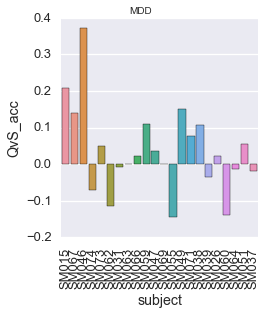

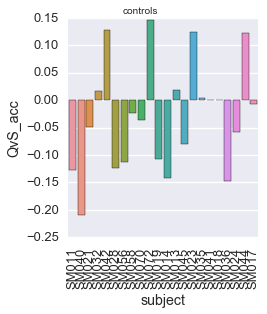

In [81]:
g = sns.factorplot(y='QvS_acc',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'MDD'],kind='bar')
g.set_xticklabels(rotation=90)
plt.suptitle('MDD')

g = sns.factorplot(y='QvS_acc',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'control'],kind='bar')
g.set_xticklabels(rotation=90)
plt.suptitle('controls')

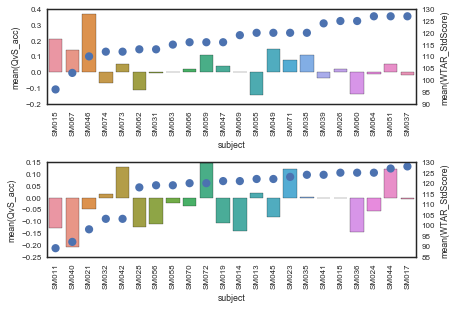

In [82]:
sns.set_style('white')
sns.set_context('paper')

fig = plt.figure()
ax1 = fig.add_subplot(211)
g = sns.barplot(y='QvS_acc',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'MDD'],ax=ax1)
g.set_xticklabels(table_MI_wtar[table_MI_wtar.group == 'MDD']['subject'],rotation=90)
h = sns.pointplot(y='WTAR_StdScore',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'MDD'],\
                  join=False,ax=ax1.twinx())

ax2 = fig.add_subplot(212)
g = sns.barplot(y='QvS_acc',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'control'],ax=ax2)
g.set_xticklabels(table_MI_wtar[table_MI_wtar.group == 'control']['subject'],rotation=90)
h = sns.pointplot(y='WTAR_StdScore',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'control'],\
                  join=False,ax=ax2.twinx())

fig.tight_layout()

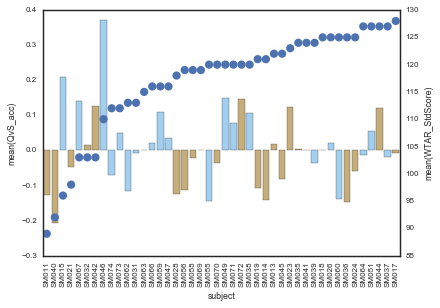

In [83]:
sns.set_style('white')
sns.set_context('paper')

pal_dict = {'control':sns.xkcd_rgb['tan'],'MDD':sns.xkcd_rgb['light blue']}
fig = plt.figure()
ax1 = fig.add_subplot(111)
g = sns.barplot(y='QvS_acc',x='subject',palette = table_MI_wtar['group'].map(pal_dict),data=table_MI_wtar,ax=ax1)
g.set_xticklabels(table_MI_wtar['subject'],rotation=90)
h = sns.pointplot(y='WTAR_StdScore',x='subject',data=table_MI_wtar,join=False,ax=ax1.twinx())
plt.savefig(path2figs + 'Q-S_by_WTAR.pdf')

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


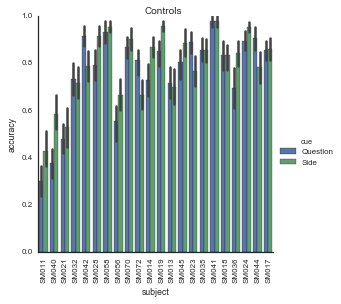

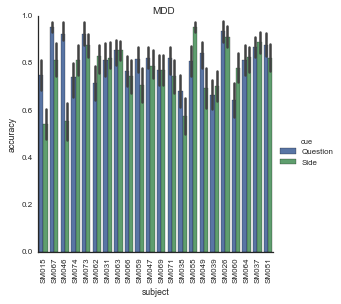

In [84]:
noe_nog_MI_wtar_hc = noe_nog_MI_wtar[noe_nog_MI_wtar.group == 'control']
noe_nog_MI_wtar_hc.sort_values('WTAR_StdScore',inplace=True)

noe_nog_MI_wtar_mdd = noe_nog_MI_wtar[noe_nog_MI_wtar.group == 'MDD']
noe_nog_MI_wtar_mdd.sort_values('WTAR_StdScore',inplace=True)

g = sns.factorplot(y='accuracy',x='subject',hue='cue',ci=68,kind='bar',data=noe_nog_MI_wtar_hc,
                  hue_order=['Question','Side'])
g.set_xticklabels(rotation=90)
plt.suptitle('Controls')

g = sns.factorplot(y='accuracy',x='subject',hue='cue',ci=68,kind='bar',data=noe_nog_MI_wtar_mdd,
                  hue_order=['Question','Side'])
g.set_xticklabels(rotation=90)
plt.suptitle('MDD')

Okay, so the **bottom line** here is we have a Group x Cue effect for words from the mobility task but not the animacy task. For words from both tasks, we isolate the Cue effect by performing Q-S subtractions. For words from the mobility task, that difference score is more positive in MDD vs. HC, but for words from the animacy task, there is no group difference. This indicates that the MDD group was more affected by the cueing manipulation than the HC group for words from the mobility task, with the Qcue supporting the highest level of accuracy in MDD (when paired with words from the mobility task). This is in line with the idea that MDDs do best with deep encoding followed by conceptual retrieval (may be worth re-reading Ed Watkins's work on conceptual implicit retrieval in MDD).

### Correct RT 

#### Odd/Even 

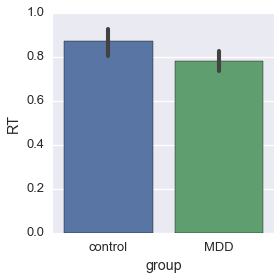

In [85]:
# Shows that on Odd/Even trials, the MDDs are actually a bit faster than the controls. No psychomotor slowing here!
sns.set_style('darkgrid')
sns.set_context('talk')
oe_corr = oe[oe.accuracy == 1]
sns.factorplot(y='RT',x='group',units='subject',ci=68,kind='bar',data=oe_corr)

In [86]:
# Drop the 2 subs with no RT data, then run a t-test on the group difference in correct RT on Odd/Even trials.
# No difference. 

oe_corr_clean = oe_corr[~((oe_corr.subject == 'SM045') | (oe_corr.subject == 'SM046'))]
g = oe_corr_clean.groupby(['group','subject'])['RT_ms'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
print df.groupby('group')['RT_ms'].mean()
print df.groupby('group')['RT_ms'].std()
misc.ttest_2s(df[df.group == 'control']['RT_ms'],df[df.group == 'MDD']['RT_ms'])

group
MDD        781.276577
control    867.724727
Name: RT_ms, dtype: float64
group
MDD        227.829583
control    301.940819
Name: RT_ms, dtype: float64
t(44) = 1.10, p = 0.279


(1.096070238425223, 0.27901113705842495)

#### Group x Cue x Task 

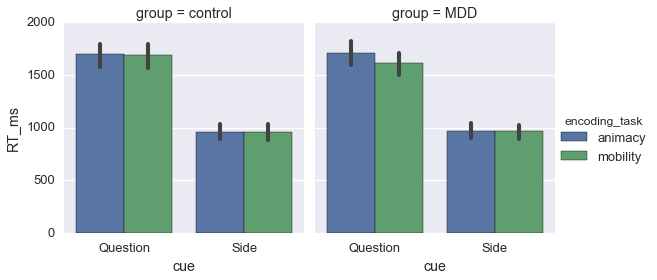

In [87]:
# Strong effect of Cue, no big effects of Group or Task, maybe a Group x Cue x Task . . . 
noe_nog_corr = noe_nog[noe_nog.accuracy == 1]
sns.factorplot(y='RT_ms',x='cue',hue='encoding_task',col='group',units='subject',ci=68,kind='bar',data=noe_nog_corr)

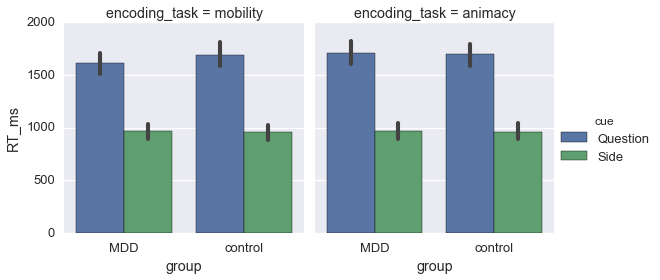

In [88]:
sns.factorplot(y='RT_ms',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',data=noe_nog_corr,
              order = ['MDD','control'],col_order=['mobility','animacy'])
sns.plt.savefig(path2figs + 'Ret_RT_GxCxT_new.pdf')

In [89]:
# First drop the two subs with no RT data, then run the ANOVA--on lnRT because that is more normally distributed.
# The only sig effect is the huge Cue effect.

noe_nog_corr_clean = noe_nog_corr[~((noe_nog_corr.subject == 'SM045') | (noe_nog_corr.subject == 'SM046'))]
%Rpush noe_nog_corr_clean
# %R str(noe_nog_corr_clean)

%R ret_rt <- aov_ez(id='subject', dv='lnRT', within=c('cue','encoding_task'), between='group', data=noe_nog_corr_clean)
%R print(ret_rt)

Anova Table (Type 3 tests)

Response: lnRT
                   Effect    df  MSE          F    ges p.value
1                   group 1, 44 0.35       0.04  .0008     .83
2                     cue 1, 44 0.06 267.92 ***    .44  <.0001
3               group:cue 1, 44 0.06       0.03 <.0001     .87
4           encoding_task 1, 44 0.01     3.30 +   .002     .08
5     group:encoding_task 1, 44 0.01       1.26  .0007     .27
6       cue:encoding_task 1, 44 0.01       0.54  .0004     .47
7 group:cue:encoding_task 1, 44 0.01       1.63   .001     .21

Sphericity correction method: GG 


In [90]:
# Here are the descriptives on the Cue effect (RT in ms here)
g = noe_nog_corr_clean.groupby(['subject','group','cue','encoding_task'])['RT_ms'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
print df.groupby('cue')['RT_ms'].mean()
print df.groupby('cue')['RT_ms'].std()

%Rpush df
%R ret_RT_cue.es <- cohen.d(RT_ms ~ cue, data=df)
%R print(ret_RT_cue.es)

cue
Question    1685.929933
Side         974.033703
Name: RT_ms, dtype: float64
cue
Question    527.486717
Side        323.672585
Name: RT_ms, dtype: float64



Cohen's d

d estimate: 1.62678 (large)
95 percent confidence interval:
     inf      sup 
1.288879 1.964680 


So the **bottom line** with respect to correct RT is that there is only one strong effect: everyone is slower in response to the Question cue vs. the Side cue.

### Confidence 

Confidence is coded as "high" or "low", which isn't super helpful for ANOVAs, so let's re-express that as the percentage of high confidence responses . . . . 

In [91]:
oe['high_confidence'] = oe.confidence.apply(lambda x: 1 if x == 'high' else 0)
noe_nog['high_confidence'] = noe_nog.confidence.apply(lambda x: 1 if x == 'high' else 0)

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


#### Odd/Even 

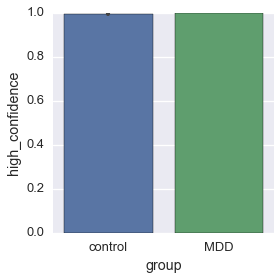

In [92]:
# Shows that eveybody is super confidence on Odd/Even trials.
sns.factorplot(y='high_confidence',x='group',units='subject',ci=68,kind='bar',data=oe)

In [93]:
g = oe.groupby(['subject','group'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
print 100*(df.groupby('group')['high_confidence'].mean())
print 100*(df.groupby('group')['high_confidence'].std())
misc.ttest_2s(df[df.group == 'control']['high_confidence'],df[df.group == 'MDD']['high_confidence'])

group
MDD        99.869792
control    99.608461
Name: high_confidence, dtype: float64
group
MDD        0.351908
control    0.676259
Name: high_confidence, dtype: float64
t(46) = -1.68, p = 0.100


(-1.6793673721428914, 0.099861348044052459)

#### Group x Cue x Task 

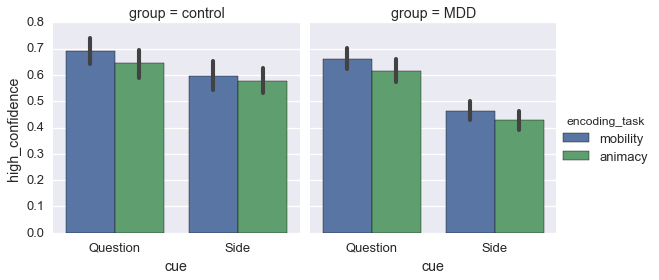

In [94]:
# So I'm seeing main effects of Cue (Q > S), Task (mobility > animacy, and probably a Group x Cue interaction
# because there appears to be HC > MDD under Side but not Cue
sns.factorplot(y='high_confidence',x='cue',hue='encoding_task',col='group',units='subject',ci=68,kind='bar',
               data=noe_nog)

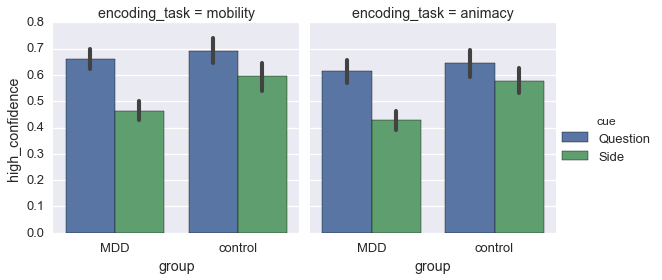

In [95]:
sns.factorplot(y='high_confidence',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',
               data=noe_nog,order = ['MDD','control'],col_order=['mobility','animacy'])
sns.plt.savefig(path2figs + 'Ret_Conf_GxCxT_new.pdf')

In [96]:
# Let's get some descriptives
g = noe_nog.groupby(['subject','group','cue','encoding_task'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
# df.head()
print 100*(df.groupby(['group','cue','encoding_task'])['high_confidence'].mean())
print '\n'
print 100*(df.groupby(['group','cue','encoding_task'])['high_confidence'].std())

# Want to see the task effect on its own . . . 
print 100*(df.groupby(['encoding_task'])['high_confidence'].mean())
print '\n'
print 100*(df.groupby(['encoding_task'])['high_confidence'].std())

group    cue       encoding_task
MDD      Question  animacy          61.239202
                   mobility         65.683890
         Side      animacy          42.123773
                   mobility         45.605873
control  Question  animacy          63.176656
                   mobility         68.213969
         Side      animacy          56.501553
                   mobility         58.601712
Name: high_confidence, dtype: float64


group    cue       encoding_task
MDD      Question  animacy          19.686083
                   mobility         18.767043
         Side      animacy          18.273272
                   mobility         17.882383
control  Question  animacy          26.250076
                   mobility         23.467545
         Side      animacy          24.145861
                   mobility         25.752042
Name: high_confidence, dtype: float64
encoding_task
animacy     55.760296
mobility    59.526361
Name: high_confidence, dtype: float64


encoding_task
animacy 

In [97]:
# Yup, main effects of Cue and Task plus a Group x Cue interaction

%Rpush noe_nog
# %R str(noe_nog)

%R ret_conf <- aov_ez(id='subject',dv='high_confidence', within=c('cue','encoding_task'), between='group', data=noe_nog)
%R print(ret_conf)

Anova Table (Type 3 tests)

Response: high_confidence
                   Effect    df  MSE         F    ges p.value
1                   group 1, 46 0.14      2.11    .03     .15
2                     cue 1, 46 0.04 24.85 ***    .09  <.0001
3               group:cue 1, 46 0.04    4.24 *    .02     .05
4           encoding_task 1, 46 0.01   7.91 **   .008    .007
5     group:encoding_task 1, 46 0.01      0.02 <.0001     .88
6       cue:encoding_task 1, 46 0.00      1.12  .0005     .30
7 group:cue:encoding_task 1, 46 0.00      0.29  .0001     .60

Sphericity correction method: GG 


In [98]:
# First follow-up the main effect of task
g = noe_nog.groupby(['subject','group','encoding_task'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

misc.ttest_2s(df[df.encoding_task == 'mobility']['high_confidence'],
              df[df.encoding_task == 'animacy']['high_confidence'],
              paired=True)

%Rpush df
%R conf_task.es <- cohen.d(high_confidence ~ encoding_task, data=df, paired=TRUE)
%R print(conf_task.es)

t(47) = 2.94, p = 0.005



Cohen's d

d estimate: -0.1344215 (negligible)
95 percent confidence interval:
       inf        sup 
-0.5444758  0.2756329 


In [215]:
# Okay, so let's just run b/w group t-tests on % high confidence responses at each level of cue
g = noe_nog.groupby(['subject','group','cue'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

# Question: no difference
misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['high_confidence'],
              df[(df.group == 'MDD') & (df.cue == 'Question')]['high_confidence'], paired=False)

# Side: group difference, HC > MDD
misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Side')]['high_confidence'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['high_confidence'], paired=False)


# Examining cue effect on confidence in controls
misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['high_confidence'],
              df[(df.group == 'control') & (df.cue == 'Side')]['high_confidence'], paired=True)

# Examining cue effect on confidence in MDD
misc.ttest_2s(df[(df.group == 'MDD') & (df.cue == 'Question')]['high_confidence'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['high_confidence'], paired=True)

%Rpush df
%R conf_GxC.es <- cohen.d(high_confidence ~ group, data=subset(df, cue=='Side'), paired=FALSE)
%R print(conf_GxC.es)

t(46) = 0.36, p = 0.722
t(46) = 2.25, p = 0.030
t(23) = 2.07, p = 0.050
t(23) = 5.06, p = 0.000



Cohen's d

d estimate: 0.6483187 (medium)
95 percent confidence interval:
       inf        sup 
0.03869432 1.25794307 


In [100]:
# Let's see if the Question > Side effect on confidence is there for both encoding tasks considered separately in MDD.
# I think so and want to highlight this as it contrasts with what we see for guesses and accuracy (and this suggests
# to me that the ERP effect we see over left parietal is tracking those and not confidence)

g = noe_nog.groupby(['subject','group','cue','encoding_task'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

misc.ttest_2s(df[(df.group == 'MDD') & (df.encoding_task == 'animacy') & (df.cue == 'Question')]['high_confidence'],
              df[(df.group == 'MDD') & (df.encoding_task == 'animacy') & (df.cue == 'Side')]['high_confidence'],
              paired=True)

misc.ttest_2s(df[(df.group == 'MDD') & (df.encoding_task == 'mobility') & (df.cue == 'Question')]['high_confidence'],
              df[(df.group == 'MDD') & (df.encoding_task == 'mobility') & (df.cue == 'Side')]['high_confidence'],
              paired=True)

%Rpush df
%R mdd_cue_conf_LNL.es <- cohen.d(high_confidence ~ cue, data=subset(df, group=='MDD' & encoding_task=='animacy'))
%R print(mdd_cue_conf_LNL.es)

%R mdd_cue_conf_MI.es <- cohen.d(high_confidence ~ cue, data=subset(df, group=='MDD' & encoding_task=='mobility'))
%R print(mdd_cue_conf_MI.es)

t(23) = 4.36, p = 0.000
t(23) = 5.35, p = 0.000



Cohen's d

d estimate: 1.006456 (large)
95 percent confidence interval:
      inf       sup 
0.3748886 1.6380225 



Cohen's d

d estimate: 1.095361 (large)
95 percent confidence interval:
      inf       sup 
0.4570315 1.7336899 


So the **bottom line** with respect to confidence is that everybody is more confident in response to the Question vs. the Side cue and in response to words from the mobility vs. the animacy task, and the depressed group was less confident than the control group under the Side cue.

## ERPs 

Let's try the same Group x Cue x Task approach with the ANOVAs, relying on the MUT. The challenge with that is that's it not possible to simply run the ANOVA in one-step, so we will need to do it in a more piecemeal fashion. Here's how: (1) in controls, compute a "mobility - animacy" difference wave under the Question cue (so Q:M-A), repeat that under the Side cue (so S:M-A), and the compute a difference of differences (so Q:M-A minus S:M-A); (2) repeat all that in the MDD group; and (3) do Controls vs. MDD for Q:M-A minus S:M-A. That is the equivalent of the full 2 x 2 x 2 ANOVA. If we find significant group differences, we can look at the waveforms in electrodes that show the difference.

In [101]:
%cd {path2erps}

/Users/danieldillon/Work/Expts/SOURCE/Analysis/ERPs


In [102]:
#clean up csv files, adding in columns for cue, task, and laterality

def elec2laterality(electrode):
       
    left = [48,49,43,56,44,38,57,63,128,39,45,50,32,33,40,46,58,64,68,34,51,35,41,47,25,26,27,59,65,28,52,36,69,
           42,23,29,73,24,53,22,60,66,21,20,30,37,70,127,18,19,13,31,54,61,67,74,71,12,7]
    right = [5,106,126,10,4,112,80,79,78,77,76,82,14,118,105,87,83,9,86,85,84,88,3,124,111,104,93,89,117,92,8,2,
             123,98,91,90,110,103,116,97,1,122,109,102,96,95,94,115,108,101,125,121,114,100,99,120,113,107,119]
    midline = [17,15,16,11,6,55,62,72,75,81]
    
    if electrode in left:
        laterality = 'left'
    elif electrode in right:
        laterality = 'right'
    elif electrode in midline:
        laterality = 'midline'

    return laterality

def condition2task(condition):
    
    animacy = [97,111]
    mobility = [104,118]
    
    if condition in animacy:
        task = 'animacy'
    elif condition in mobility:
        task = 'mobility'

    return task

def condition2cue(condition):
    
    side = [97,104]
    question = [111,118]
    
    if condition in side:
        cue = 'Side'
    elif condition in question:
        cue = 'Question'

    return cue
    
def make_clean_df(csv):
    '''Read in a mean amps CSV and return a cleaned up df.'''
    df = pd.read_csv(csv,sep="\t",skipinitialspace=True)
    new_cols = ['time','uV','electrode','electrode_label','condition','subject']
    df.columns = new_cols
    df.electrode_label.replace({'E60':'P1','E52':'P3','E51':'P5',
                                'E58':'P7','E85':'P2','E92':'P4','E97':'P6',
                                'E96':'P8','E26':'AF7','E19':'F1',
                                'E24':'F3','E27':'F5','E33':'F7',
                               'E2':'AF8','E4':'F2','E124':'F4',
                                'E123':'F6','E122':'F8',
                               'E67':'PO3','E70':'O1','E62':'Pz',
                                'E72':'POz','E75':'Oz','E77':'PO4','E83':'O2'},
                               inplace=True)    
    df.subject = df.subject.map(lambda x: x.strip('_ERPs'))
    df['laterality'] = df.electrode.map(lambda x: elec2laterality(x))
    df['task'] = df.condition.map(lambda x: condition2task(x))
    df['cue'] = df.condition.map(lambda x: condition2cue(x))
    df = df[['subject','time','condition','cue','task','laterality',
             'electrode','electrode_label','uV']]
    df.condition.replace({97:'animacy side hit', 104:'mobility side hit', 
                          111:'animacy question hit',
                          118:'mobility question hit'},inplace=True)
    
    return df

### The following analyses are based on the traditional 4 left (P3, P5, P7, P1) and 4 right (P4, P6, P8, P2) electrodes

In [103]:
hc_par = make_clean_df(path2erps + 'MeanAmps/HC/HC_EncTask_RetCue_Parietal_400_800.txt')
mdd_par = make_clean_df(path2erps + 'MeanAmps/MDD/MDD_EncTask_RetCue_Parietal_400_800.txt')
hc_par['group'] = 'control'
mdd_par['group'] = 'MDD'
all_par = pd.concat([hc_par,mdd_par])
all_par.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
0,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,51,P5,-0.992,control
1,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,52,P3,1.481,control
2,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,58,P7,-0.048,control
3,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,60,P1,-1.063,control
4,SM011,[400.0 800.0],animacy side hit,Side,animacy,right,85,P2,-0.861,control


In [104]:
all_par.electrode_label.unique()

array(['P5', 'P3', 'P7', 'P1', 'P2', 'P4', 'P8', 'P6'], dtype=object)

In [105]:
all_par.groupby('group')['subject'].nunique()

group
MDD        24
control    24
Name: subject, dtype: int64

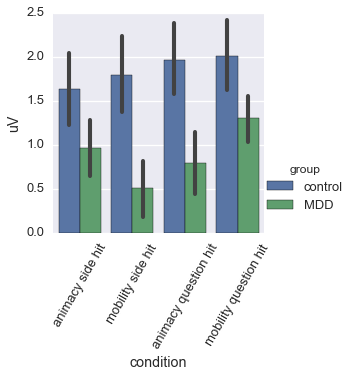

In [106]:
f = sns.factorplot(y = 'uV', x = 'condition',hue='group',kind='bar',units='subject',ci=68,
                   data=all_par)
f.set_xticklabels(rotation=60)

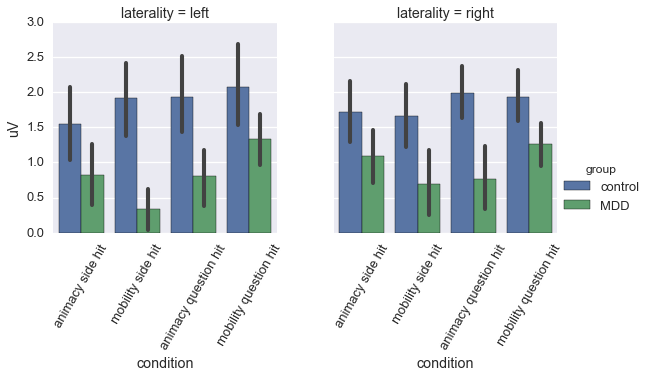

In [107]:
f = sns.factorplot(y = 'uV', x = 'condition',hue='group',col='laterality',kind='bar',units='subject',ci=68,
                   data=all_par)
f.set_xticklabels(rotation=60)

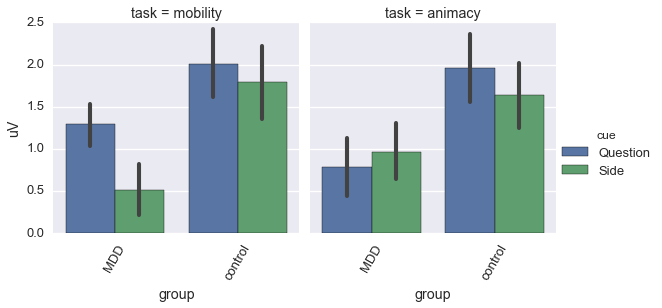

In [108]:
f = sns.factorplot(y = 'uV', x = 'group',hue='cue',col='task',kind='bar',units='subject',ci=68,
                   data=all_par, order =['MDD','control'],col_order=['mobility','animacy'],hue_order=['Question','Side'])
f.set_xticklabels(rotation=60)
sns.plt.savefig(path2figs + 'Par_uV_GxCxT.pdf')

In [109]:
#significant effect of group and cue, but not for GroupxCuexTask (though trending in the direction)

%Rpush all_par

%R erp_par <- ezANOVA(dv=uV, wid=subject, within=.(cue,task,laterality), between=group, data=all_par)
%R print(erp_par)

/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

  warnings.warn(x, RRuntimeWarning)


$ANOVA
                      Effect DFn DFd           F          p p<.05          ges
2                      group   1  46  4.48335496 0.03966354     * 5.293110e-02
3                        cue   1  46 10.34378385 0.00237944     * 5.040041e-03
5                       task   1  46  0.37900348 0.54117126       2.651048e-04
7                 laterality   1  46  0.02152881 0.88398868       1.214792e-04
4                  group:cue   1  46  0.03700366 0.84830432       1.812116e-05
6                 group:task   1  46  0.10860080 0.74323871       7.597829e-05
8           group:laterality   1  46  0.08108244 0.77711390       4.573648e-04
9                   cue:task   1  46  1.95804988 0.16842945       2.697534e-03
11            cue:laterality   1  46  1.41796608 0.23984712       5.016650e-04
13           task:laterality   1  46  0.79427935 0.37744735       2.920873e-04
10            group:cue:task   1  46  3.17517741 0.08136696       4.367004e-03
12      group:cue:laterality   1  46  1.40922

In [110]:
g = all_par.groupby(['subject','group','condition'])['uV'].mean()

df2=pd.DataFrame(g)
df2.reset_index(inplace=True)

df2.head()

,subject,group,condition,uV
0,SM011,control,animacy question hit,1.505500
1,SM011,control,animacy side hit,-0.317625
2,SM011,control,mobility question hit,1.684625
3,SM011,control,mobility side hit,0.959875
4,SM013,control,animacy question hit,1.938375


In [111]:
df3 = df2.pivot_table(index=['subject','group'], columns='condition', values='uV')
df3.reset_index(drop=False,inplace=True)
df3.columns = ['subject','group','animacy question','animacy side','mobility question','mobility side']
df3.head()

,subject,group,animacy question,animacy side,mobility question,mobility side
0,SM011,control,1.505500,-0.317625,1.684625,0.959875
1,SM013,control,1.938375,1.436750,3.152250,1.768750
2,SM014,control,-0.235000,-1.564125,-1.428875,-0.442625
3,SM015,MDD,1.306375,0.613625,1.887500,1.378250
4,SM017,control,3.690625,4.321750,4.313875,4.182875


In [112]:
df3['animacy q-s'] = df3['animacy question']-df3['animacy side']
df3['mobility q-s'] = df3['mobility question']-df3['mobility side']

In [113]:
df3.head()

,subject,group,animacy question,animacy side,mobility question,mobility side,animacy q-s,mobility q-s
0,SM011,control,1.505500,-0.317625,1.684625,0.959875,1.823125,0.72475
1,SM013,control,1.938375,1.436750,3.152250,1.768750,0.501625,1.38350
2,SM014,control,-0.235000,-1.564125,-1.428875,-0.442625,1.329125,-0.98625
3,SM015,MDD,1.306375,0.613625,1.887500,1.378250,0.692750,0.50925
4,SM017,control,3.690625,4.321750,4.313875,4.182875,-0.631125,0.13100


In [114]:
animacy_diff = df3[['subject', 'group', 'animacy q-s']].copy()
animacy_diff['task'] = 'animacy'
animacy_diff.columns = ['subject','group','value','task']

mobility_diff=df3[['subject','group','mobility q-s']].copy()
mobility_diff['task'] = 'mobility'
mobility_diff.columns = ['subject','group','value','task']

In [115]:
# Question-Side by task
g = pd.concat([mobility_diff,animacy_diff])
df4 = pd.DataFrame(g)
df4.head()

,subject,group,value,task
0,SM011,control,0.72475,mobility
1,SM013,control,1.38350,mobility
2,SM014,control,-0.98625,mobility
3,SM015,MDD,0.50925,mobility
4,SM017,control,0.13100,mobility


In [116]:
%Rpush df4

%R uv_par <- ezANOVA(dv=value, wid=subject, within=task, between=group, data=df4)
%R print (uv_par)

$ANOVA
      Effect DFn DFd          F          p p<.05          ges
2      group   1  46 0.03700366 0.84830432       0.0002104965
3       task   1  46 1.95804988 0.16842945       0.0304680535
4 group:task   1  46 3.17517741 0.08136696       0.0484887256



In [117]:
misc.ttest_2s(df4[(df4.group == 'control') & (df4.task == 'mobility')]['value'],
             df4[(df4.group == 'MDD') & (df4.task == 'mobility')]['value'], paired=False)

misc.ttest_2s(df4[(df4.group == 'control') & (df4.task == 'animacy')]['value'],
             df4[(df4.group == 'MDD') & (df4.task == 'animacy')]['value'],paired = False)

misc.ttest_2s(df4[(df4.group == 'control') & (df4.task == 'mobility')]['value'],
             df4[(df4.group == 'control') & (df4.task == 'animacy')]['value'], paired = True)

misc.ttest_2s(df4[(df4.group == 'MDD') & (df4.task == 'mobility')]['value'],
             df4[(df4.group == 'MDD') & (df4.task == 'animacy')]['value'], paired = True)

t(46) = -1.70, p = 0.096
t(46) = 1.38, p = 0.175
t(23) = -0.32, p = 0.749
t(23) = 1.97, p = 0.061


(1.9711360791482013, 0.060857240700011667)

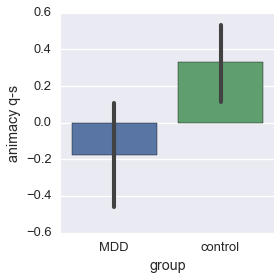

In [118]:
sns.factorplot(y='animacy q-s',x='group',units='subject',ci=68,kind='bar',data=df3, order =['MDD','control'])
sns.plt.savefig(path2figs + 'Par_uV_animacy_diff.pdf')

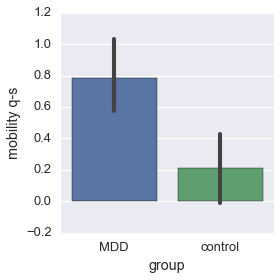

In [119]:
sns.factorplot(y='mobility q-s',x='group',units='subject',ci=68,kind='bar',data=df3, order = ['MDD','control'])
sns.plt.savefig(path2figs + 'Par_uV_mobility_diff.pdf')

In [120]:
g = all_par.groupby(['subject','group','cue','task'])['uV'].mean()
df5=pd.DataFrame(g)
df5.reset_index(inplace=True)

In [121]:
#New table for mobility accuracy
MI_acc = table_MI[['subject', 'group', 'Q_acc','S_acc','QvS_acc']].copy()

MI_acc.columns = ['subject','group','mobility question acc','mobility side acc','mobility Q-S acc']

In [122]:
#New table for animacy accuracy
LNL_acc = table_LNL[['subject', 'group', 'Q_acc','S_acc','QvS_acc']].copy()

LNL_acc.columns = ['subject','group','animacy question acc','animacy side acc','animacy Q-S acc']

In [123]:
#merging mobility and animacy tables to make full accruacy table with relevant information

acc_table = pd.merge(MI_acc,LNL_acc,on=['subject','group'])

In [124]:
# Table with accuracy and uV for task+cue and task question-side
uv_acc= pd.merge(df3,acc_table,on=['subject','group'])
uv_acc.head()

,subject,group,animacy question,animacy side,mobility question,mobility side,animacy q-s,mobility q-s,mobility question acc,mobility side acc,mobility Q-S acc,animacy question acc,animacy side acc,animacy Q-S acc
0,SM011,control,1.505500,-0.317625,1.684625,0.959875,1.823125,0.72475,0.297872,0.425532,-0.127660,0.708333,0.437500,0.270833
1,SM013,control,1.938375,1.436750,3.152250,1.768750,0.501625,1.38350,0.717391,0.700000,0.017391,0.476190,0.790698,-0.314507
2,SM014,control,-0.235000,-1.564125,-1.428875,-0.442625,1.329125,-0.98625,0.727273,0.869565,-0.142292,0.723404,0.941176,-0.217772
3,SM015,MDD,1.306375,0.613625,1.887500,1.378250,0.692750,0.50925,0.750000,0.541667,0.208333,0.395833,0.541667,-0.145833
4,SM017,control,3.690625,4.321750,4.313875,4.182875,-0.631125,0.13100,0.854167,0.860465,-0.006298,0.659574,0.780488,-0.120913


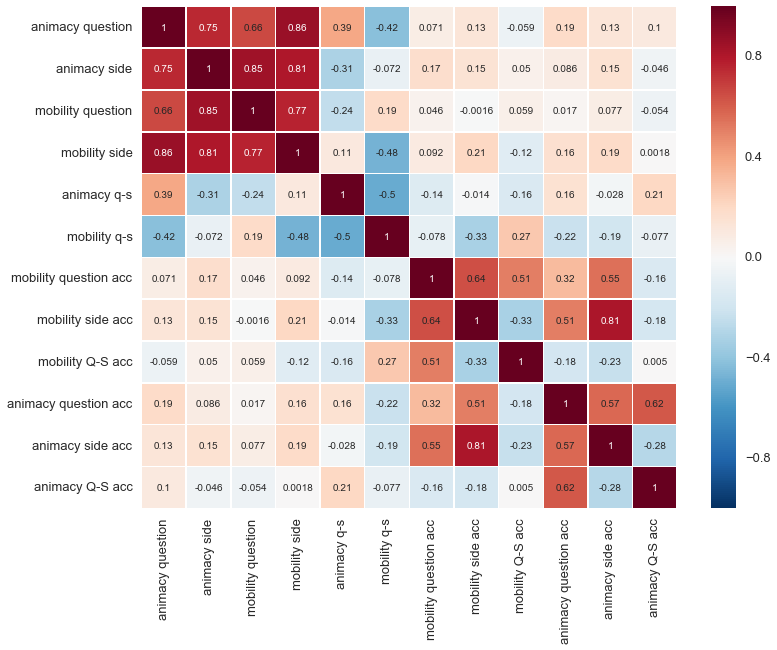

In [125]:
corr = uv_acc.corr()


f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, annot=True, linewidths=.5)
plt.show()


In [126]:
df5_LNL = df5[df5.task == 'animacy']
%Rpush df5_LNL

%R df5_LNL <- ezANOVA(dv=uV, wid=subject, within=cue, between=group, data=df5_LNL)
%R print(df5_LNL)

$ANOVA
     Effect DFn DFd         F          p p<.05          ges
2     group   1  46 3.7527604 0.05887524       0.0664434521
3       cue   1  46 0.1817824 0.67183458       0.0005039715
4 group:cue   1  46 1.9007287 0.17466481       0.0052445657



In [127]:
df5_MI = df5[df5.task == 'mobility']
%Rpush df5_MI

%R df5_MI <- ezANOVA(dv=uV, wid=subject, within=cue, between=group, data=df5_MI)
%R print(df5_MI)

$ANOVA
     Effect DFn DFd        F           p p<.05         ges
2     group   1  46 4.800646 0.033552522     * 0.084032749
3       cue   1  46 8.812984 0.004736857     * 0.022642716
4 group:cue   1  46 2.885562 0.096131828       0.007528365



### The following analyses are conducted using the electrodes found to be significant under Question-Side/Depressed-Controls for the MUT analysis.

In [128]:
# for 400-800 ms
hc_par3 = make_clean_df(path2erps + 'MeanAmps/HC/HC_cueDiff_taskDiff_Par_400_800.txt')
mdd_par3 = make_clean_df(path2erps + 'MeanAmps/MDD/MDD_cueDiff_taskDiff_Par_400_800.txt')
hc_par3['group'] = 'control'
mdd_par3['group'] = 'MDD'
all_par3 = pd.concat([hc_par3,mdd_par3],axis=0)
all_par3.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
0,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,34,E34,-0.081,control
1,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,35,E35,2.240,control
2,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,40,E40,2.227,control
3,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,41,E41,2.679,control
4,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,42,E42,1.070,control


In [129]:
all_par3.electrode_label.unique()

array(['E34', 'E35', 'E40', 'E41', 'E42', 'E46', 'E47', 'P5', 'P3', 'E53'], dtype=object)

In [130]:
# Group x Cue X Task within significant electrodes in MUT analysis
%Rpush all_par3

%R uv_par3 <- aov_ez(dv='uV', id='subject', within=c('task', 'cue'), between='group', data=all_par3)
%R print(uv_par3)

Anova Table (Type 3 tests)

Response: uV
          Effect    df  MSE       F   ges p.value
1          group 1, 46 7.07    0.94   .01     .34
2           task 1, 46 0.71    1.98  .003     .17
3     group:task 1, 46 0.71    0.08 .0001     .78
4            cue 1, 46 0.65    0.98  .001     .33
5      group:cue 1, 46 0.65  3.35 +  .005     .07
6       task:cue 1, 46 1.09    1.88  .005     .18
7 group:task:cue 1, 46 1.09 8.23 **   .02    .006

Sphericity correction method: GG 


In [131]:
# Group x Cue for MI words only . . . 
all_par3_MI = all_par3[all_par3.task == 'mobility']
%Rpush all_par3_MI
%R uv_par_MI <- aov_ez(dv='uV', id='subject', within='cue', between='group', data=all_par3_MI, type=3)
%R print(uv_par_MI)

Anova Table (Type 3 tests)

Response: uV
     Effect    df  MSE         F  ges p.value
1     group 1, 46 3.57      1.11  .02     .30
2       cue 1, 46 0.54      0.37 .001     .54
3 group:cue 1, 46 0.54 18.49 ***  .05  <.0001

Sphericity correction method: GG 


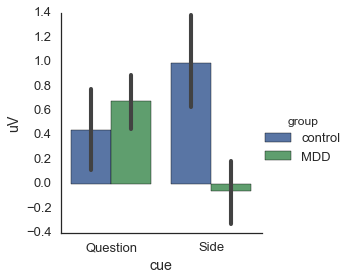

In [132]:
sns.set_style('white')
sns.factorplot(y='uV',x='cue',hue='group',units='subject',ci=68,kind='bar',data=all_par3_MI,
              order=['Question','Side'])
sns.plt.savefig(path2figs + 'Group_x_Cue_MI_MUT_400-800_LeftParElects.pdf')

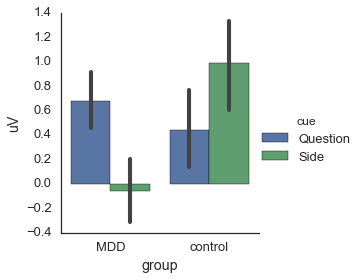

In [133]:
sns.set_style('white')
sns.factorplot(y='uV',x='group',hue='cue',units='subject',ci=68,kind='bar',data=all_par3_MI,
              order=['MDD','control'],hue_order=['Question','Side'])
sns.plt.savefig(path2figs + 'Group_x_Cue_MI_MUT_400-800_LeftParElects_v2.pdf')

In [134]:
g = all_par3_MI.groupby(['subject','group','cue'])['uV'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['uV'],
              df[(df.group == 'MDD') & (df.cue == 'Question')]['uV'],
              paired=False)

misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Side')]['uV'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['uV'],
              paired=False)

misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['uV'],
              df[(df.group == 'control') & (df.cue == 'Side')]['uV'],
              paired=True)

misc.ttest_2s(df[(df.group == 'MDD') & (df.cue == 'Question')]['uV'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['uV'],
              paired=True)

t(46) = -0.64, p = 0.525
t(46) = 2.34, p = 0.023
t(23) = -2.99, p = 0.007
t(23) = 3.12, p = 0.005


(3.1216444636751945, 0.0047950054835911781)

In [135]:
df.head()

,subject,group,cue,uV
0,SM011,control,Question,0.9477
1,SM011,control,Side,0.9382
2,SM013,control,Question,0.7688
3,SM013,control,Side,1.0773
4,SM014,control,Question,0.1516


In [136]:
# Compute effect sizes for Question and Side ERP comparisons from 400-800

%Rpush df
# %R str(df)
%R par3_HCvsMDD_Q.es <- cohen.d(uV ~ group, data=subset(df, cue=='Question'), paired=FALSE)
%R par3_HCvsMDD_S.es <- cohen.d(uV ~ group, data=subset(df, cue=='Side'), paired=FALSE)
%R par3_HC_QvsS.es <- cohen.d(uV ~ cue, data=subset(df, group=='control'), paired=TRUE)
%R par3_MDD_QvsS.es <- cohen.d(uV ~ cue, data=subset(df, group=='MDD'), paired=TRUE)

%R print(par3_HCvsMDD_Q.es)
%R print(par3_HCvsMDD_S.es)
%R print(par3_HC_QvsS.es)
%R print(par3_MDD_QvsS.es)


Cohen's d

d estimate: -0.1849187 (negligible)
95 percent confidence interval:
       inf        sup 
-0.7798115  0.4099741 



Cohen's d

d estimate: 0.6767901 (medium)
95 percent confidence interval:
       inf        sup 
0.06574538 1.28783488 



Cohen's d

d estimate: -0.2678313 (small)
95 percent confidence interval:
       inf        sup 
-0.8641722  0.3285097 



Cohen's d

d estimate: 0.5847933 (medium)
95 percent confidence interval:
        inf         sup 
-0.02187133  1.19145798 


In [137]:
# Group x Cue for LNL words only . . . no significant effects, which is what we want:) 
all_par3_LNL = all_par3[all_par3.task == 'animacy']
%Rpush all_par3_LNL
%R uv_par_LNL <- aov_ez(dv='uV', id='subject', within='cue', between='group', data=all_par3_LNL, type=3)
%R print(uv_par_LNL)

Anova Table (Type 3 tests)

Response: uV
     Effect    df  MSE    F  ges p.value
1     group 1, 46 4.21 0.65  .01     .42
2       cue 1, 46 1.21 2.07 .010     .16
3 group:cue 1, 46 1.21 0.96 .005     .33

Sphericity correction method: GG 


In [138]:
# for 800-1400 ms
hc_par4 = make_clean_df(path2erps + 'MeanAmps/HC/HC_cueDiff_taskDiff_Par_800_1400.txt')
mdd_par4 = make_clean_df(path2erps + 'MeanAmps/MDD/MDD_cueDiff_taskDiff_Par_800_1400.txt')
hc_par4['group'] = 'control'
mdd_par4['group'] = 'MDD'
all_par4 = pd.concat([hc_par4,mdd_par4],axis=0)
all_par4.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
0,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,34,E34,-1.122,control
1,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,35,E35,3.729,control
2,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,40,E40,4.433,control
3,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,41,E41,4.129,control
4,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,42,E42,0.124,control


In [139]:
%Rpush all_par4

%R uv_par4 <- aov_ez(dv='uV', id='subject', within=c('task', 'cue'), between='group', data=all_par4)
%R print(uv_par4)

Anova Table (Type 3 tests)

Response: uV
          Effect    df  MSE      F   ges p.value
1          group 1, 46 7.40 4.13 *   .06     .05
2           task 1, 46 0.75   1.53  .002     .22
3     group:task 1, 46 0.75   0.07 .0001     .79
4            cue 1, 46 1.36   0.42  .001     .52
5      group:cue 1, 46 1.36 3.24 +  .008     .08
6       task:cue 1, 46 1.72 3.17 +   .01     .08
7 group:task:cue 1, 46 1.72 5.09 *   .02     .03

Sphericity correction method: GG 


In [140]:
# Group x Cue for MI words only . . . significant interaction, as expected/desired.
all_par4_MI = all_par4[all_par4.task == 'mobility']
%Rpush all_par4_MI
%R uv_par4_MI <- aov_ez(dv='uV', id='subject', within='cue', between='group', data=all_par4_MI)
%R print(uv_par4_MI)

Anova Table (Type 3 tests)

Response: uV
     Effect    df  MSE         F  ges p.value
1     group 1, 46 3.88    3.61 +  .06     .06
2       cue 1, 46 0.89      1.42 .006     .24
3 group:cue 1, 46 0.89 14.38 ***  .06   .0004

Sphericity correction method: GG 


In [141]:
g = all_par4_MI.groupby(['subject','group','cue'])['uV'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['uV'],
              df[(df.group == 'MDD') & (df.cue == 'Question')]['uV'],
              paired=False)

misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Side')]['uV'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['uV'],
              paired=False)

misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['uV'],
              df[(df.group == 'control') & (df.cue == 'Side')]['uV'],
              paired=True)

misc.ttest_2s(df[(df.group == 'MDD') & (df.cue == 'Question')]['uV'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['uV'],
              paired=True)

t(46) = 0.08, p = 0.936
t(46) = 3.12, p = 0.003
t(23) = -2.02, p = 0.055
t(23) = 3.25, p = 0.003


(3.2537877458615392, 0.003497897074855448)

In [142]:
# Compute effect sizes for Question and Side ERP comparisons from 800-1400

%Rpush df
# %R str(df)
%R par4_HCvsMDD_Q.es <- cohen.d(uV ~ group, data=subset(df, cue=='Question'), paired=FALSE)
%R par4_HCvsMDD_S.es <- cohen.d(uV ~ group, data=subset(df, cue=='Side'), paired=FALSE)
%R par4_HC_QvsS.es <- cohen.d(uV ~ cue, data=subset(df, group=='control'), paired=TRUE)
%R par4_MDD_QvsS.es <- cohen.d(uV ~ cue, data=subset(df, group=='MDD'), paired=TRUE)

%R print(par4_HCvsMDD_Q.es)
%R print(par4_HCvsMDD_S.es)
%R print(par4_HC_QvsS.es)
%R print(par4_MDD_QvsS.es)


Cohen's d

d estimate: 0.02326955 (negligible)
95 percent confidence interval:
       inf        sup 
-0.5703219  0.6168610 



Cohen's d

d estimate: 0.9003652 (large)
95 percent confidence interval:
      inf       sup 
0.2762016 1.5245287 



Cohen's d

d estimate: -0.2056517 (small)
95 percent confidence interval:
       inf        sup 
-0.8008572  0.3895538 



Cohen's d

d estimate: 0.5515316 (medium)
95 percent confidence interval:
        inf         sup 
-0.05369985  1.15676298 


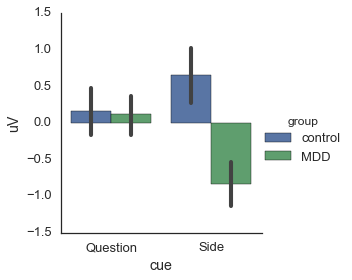

In [143]:
sns.factorplot(y='uV',x='cue',hue='group',units='subject',ci=68,kind='bar',data=all_par4_MI,
              order=['Question','Side'])
sns.plt.savefig(path2figs + 'Group_x_Cue_MI_MUT_800-1400_LeftParElects.pdf')

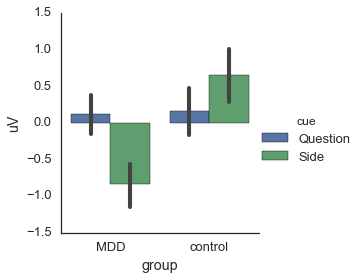

In [144]:
sns.set_style('white')
sns.factorplot(y='uV',x='group',hue='cue',units='subject',ci=68,kind='bar',data=all_par4_MI,
              order=['MDD','control'],hue_order=['Question','Side'])
sns.plt.savefig(path2figs + 'Group_x_Cue_MI_MUT_800-1400_LeftParElects_v2.pdf')

In [145]:
# Group x Cue for LNL words only . . . no significant effects (good), but there is a nearly significant effect of
# Group . . . plot in next cell shows it is due to weaker response in MDDs, overall.
all_par4_LNL = all_par4[all_par4.task == 'animacy']
%Rpush all_par4_LNL
%R uv_par4_LNL <- aov_ez(dv='uV', id='subject', within='cue', between='group', data=all_par4_LNL)
%R print(uv_par4_LNL)

Anova Table (Type 3 tests)

Response: uV
     Effect    df  MSE      F  ges p.value
1     group 1, 46 4.27 3.89 +  .05     .05
2       cue 1, 46 2.19   2.18  .02     .15
3 group:cue 1, 46 2.19   0.17 .001     .68

Sphericity correction method: GG 


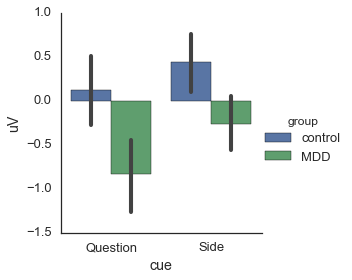

In [146]:
sns.factorplot(y='uV',x='cue',hue='group',units='subject',ci=68,kind='bar',data=all_par4_LNL,
              order=['Question','Side'])

###Follow-up tests on the group difference in Q-S uV in each time window . . .  

#### 400-800 ms 

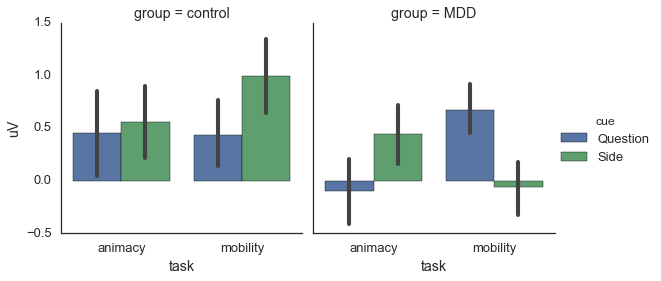

In [147]:
sns.factorplot(y='uV', x='task', hue='cue',col='group',units='subject',ci=68, kind='bar', data=all_par3,
              hue_order=['Question','Side'])

In [148]:
all_par3_MI.head()
g = all_par3_MI.groupby(['subject','group','cue'])['uV'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
par_table_MI = df.pivot_table(index=['subject','group'],columns='cue',values='uV')
par_table_MI.reset_index(inplace=True)
new_cols = ['subject','group','question','side']
par_table_MI.columns = new_cols
par_table_MI['Q-S'] = par_table_MI['question']-par_table_MI['side']
par_table_MI['condition'] = 'mobility'
par_table_MI.head()

,subject,group,question,side,Q-S,condition
0,SM011,control,0.9477,0.9382,0.0095,mobility
1,SM013,control,0.7688,1.0773,-0.3085,mobility
2,SM014,control,0.1516,0.0330,0.1186,mobility
3,SM015,MDD,1.0759,1.3718,-0.2959,mobility
4,SM017,control,1.8646,3.3084,-1.4438,mobility


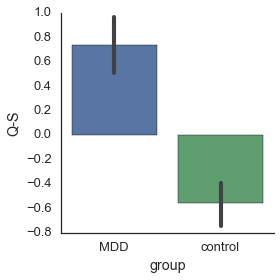

In [149]:
#Question-side for mobility uV 400-800 ms
sns.factorplot(y='Q-S',x='group',units='subject',ci=68,kind='bar',data=par_table_MI,
              order = ['MDD','control'])

In [150]:
misc.ttest_2s(par_table_MI[par_table_MI.group == 'control']['Q-S'],
             par_table_MI[par_table_MI.group == 'MDD']['Q-S'])

t(46) = -4.30, p = 0.000


(-4.2999436302497998, 8.7990055988736857e-05)

#### 800-1400 ms 

In [151]:
all_par4_MI.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
10,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,34,E34,-1.098,control
11,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,35,E35,1.106,control
12,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,40,E40,0.303,control
13,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,41,E41,-0.100,control
14,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,42,E42,1.710,control


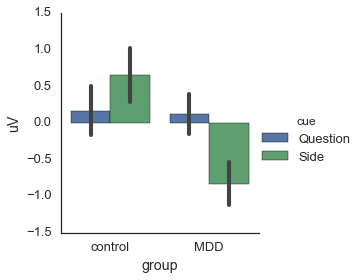

In [152]:
sns.factorplot(y='uV', x='group',hue='cue',units='subject',ci=68, kind='bar', data=all_par4_MI,
              hue_order=['Question','Side'])

In [153]:
g = all_par4_MI.groupby(['subject','group','cue'])['uV'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
par_MI_800_1400 = df.pivot_table(index=['subject','group'],columns='cue',values='uV')
par_MI_800_1400.reset_index(inplace=True)
par_MI_800_1400['Q-S'] = par_MI_800_1400.Question - par_MI_800_1400.Side
par_MI_800_1400.head()

cue,subject,group,Question,Side,Q-S
0,SM011,control,-0.3020,1.2277,-1.5297
1,SM013,control,0.6920,-0.0581,0.7501
2,SM014,control,-0.6669,-0.5852,-0.0817
3,SM015,MDD,-0.5459,0.5763,-1.1222
4,SM017,control,1.7799,3.1162,-1.3363


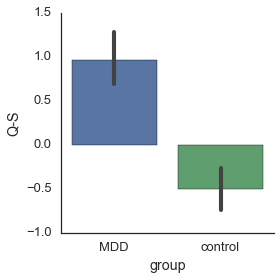

In [154]:
sns.factorplot(y='Q-S',x='group',units='subject',ci=68,kind='bar',data=par_MI_800_1400,
              order = ['MDD','control'])

In [155]:
misc.ttest_2s(par_MI_800_1400[par_MI_800_1400.group == 'control']['Q-S'],
              par_MI_800_1400[par_MI_800_1400.group == 'MDD']['Q-S'],
              paired=False)

t(46) = -3.79, p = 0.000


(-3.7918051944278517, 0.00043421063718707467)

### Correlations b/w behavior and uV from the MUT Q-S/mobility electrodes

I started doing this and was getting different results than are in the BP paper, and I realized why . . . here I start with the electrodes that showed group differences in the MUT Q-S/MI analysis, and in the BP paper I used electrodes that showed significant MUT Q-S/MI differences in the MDD group considered alone. Here I use the first approach when looking at correls across groups, and the second approach when looking at correls in MDD alone.

In [156]:
sr.head()

Item,subject,Group,Age,Gender,Race,Ethnicity,Marital_Status,Education_Level,Education_Years,Occupation,...,PSQI_Duration,PSQI_Disturb,PSQI_Latency,PSQI_DayDys,PSQI_Efficiency,PSQI_Quality,PSQI_Medication,PSQI_Total,WTAR_NatEng,WTAR_StdScore
0,SM011,0,26,f,3,0,never married,four year college,16,stay at home mom,...,0,1,0,0,0,0,0,1,yes,89
1,SM012,0,26,f,5,0,never married,four year college,16,artist,...,0,1,0,0,0,0,0,1,yes,127
2,SM013,0,55,f,5,0,never married,graduate or professional school,18,volunteer coordinator,...,1,1,0,0,0,1,0,3,yes,122
3,SM014,0,27,m,5,1,never married,graduate or professional school,17,student,...,0,1,0,0,0,1,0,2,yes,121
4,SM015,1,43,f,5,0,separated,high school,12,chef,...,2,2,2,2,2,1,1,12,yes,96


In [157]:
sr.columns

Index([        u'subject',           u'Group',             u'Age',
                u'Gender',            u'Race',       u'Ethnicity',
        u'Marital_Status', u'Education_Level', u'Education_Years',
            u'Occupation',  u'Highest Degree',          u'Income',
                 u'Notes',       u'Inclusion',       u'BDI_total',
              u'MASQ_GDA',         u'MASQ_AA',        u'MASQ_GDD',
               u'MASQ_AD',         u'RSQ_Dep',       u'RSQ_Brood',
           u'RSQ_Reflect',   u'PSQI_Duration',    u'PSQI_Disturb',
          u'PSQI_Latency',     u'PSQI_DayDys', u'PSQI_Efficiency',
          u'PSQI_Quality', u'PSQI_Medication',      u'PSQI_Total',
           u'WTAR_NatEng',   u'WTAR_StdScore'],
      dtype='object', name=u'Item')

In [158]:
table_MI.head()

,subject,group,condition,Q_acc,S_acc,QvS_acc,WTAR_NatEng,WTAR_StdScore
0,SM011,control,mobility,0.297872,0.425532,-0.127660,yes,89
1,SM013,control,mobility,0.717391,0.700000,0.017391,yes,122
2,SM014,control,mobility,0.727273,0.869565,-0.142292,yes,121
3,SM015,MDD,mobility,0.750000,0.541667,0.208333,yes,96
4,SM017,control,mobility,0.854167,0.860465,-0.006298,yes,128


In [159]:
table_MI_conf.head()

,subject,group,condition,Q_conf,S_conf,QvS_conf
0,SM011,control,mobility,0.957447,0.617021,0.340426
1,SM013,control,mobility,0.804348,0.525000,0.279348
2,SM014,control,mobility,0.522727,0.478261,0.044466
3,SM015,MDD,mobility,0.895833,0.562500,0.333333
4,SM017,control,mobility,0.416667,0.302326,0.114341


In [160]:
# Okay, let's put together a df for individual differences that's a bit cleaner . . . 
df = pd.merge(table_MI,table_MI_conf,on='subject')
df = df[['subject','group_x','condition_x','Q_acc','S_acc','QvS_acc',
         'Q_conf','S_conf','QvS_conf']]
df.rename(columns={'group_x':'group','condition_x':'condition'},inplace=True)
df.head()

,subject,group,condition,Q_acc,S_acc,QvS_acc,Q_conf,S_conf,QvS_conf
0,SM011,control,mobility,0.297872,0.425532,-0.127660,0.957447,0.617021,0.340426
1,SM013,control,mobility,0.717391,0.700000,0.017391,0.804348,0.525000,0.279348
2,SM014,control,mobility,0.727273,0.869565,-0.142292,0.522727,0.478261,0.044466
3,SM015,MDD,mobility,0.750000,0.541667,0.208333,0.895833,0.562500,0.333333
4,SM017,control,mobility,0.854167,0.860465,-0.006298,0.416667,0.302326,0.114341


In [161]:
# Now get the Q-S left parietal diffs from 400-800 ms
g = all_par3_MI.groupby(['subject','cue'])['uV'].mean()
h = g.to_frame()
h.reset_index(inplace=True)
lp48 = pd.pivot_table(h,index='subject',columns='cue',values='uV')
lp48.reset_index(inplace=True)
lp48['QvS'] = lp48.Question - lp48.Side
new_cols = ['subject','lp48_Question','lp48_Side','lp48_QvS']
lp48.columns = new_cols
lp48.head()

,subject,lp48_Question,lp48_Side,lp48_QvS
0,SM011,0.9477,0.9382,0.0095
1,SM013,0.7688,1.0773,-0.3085
2,SM014,0.1516,0.0330,0.1186
3,SM015,1.0759,1.3718,-0.2959
4,SM017,1.8646,3.3084,-1.4438


In [162]:
# Now get the Q-S left parietal diffs from 800-1400 ms
g = all_par4_MI.groupby(['subject','cue'])['uV'].mean()
h = g.to_frame()
h.reset_index(inplace=True)
lp814 = pd.pivot_table(h,index='subject',columns='cue',values='uV')
lp814.reset_index(inplace=True)
lp814['QvS'] = lp814.Question - lp814.Side
new_cols = ['subject','lp814_Question','lp814_Side','lp814_QvS']
lp814.columns = new_cols
lp814.head()

,subject,lp814_Question,lp814_Side,lp814_QvS
0,SM011,-0.3020,1.2277,-1.5297
1,SM013,0.6920,-0.0581,0.7501
2,SM014,-0.6669,-0.5852,-0.0817
3,SM015,-0.5459,0.5763,-1.1222
4,SM017,1.7799,3.1162,-1.3363


In [163]:
# Now merge all that
df = pd.merge(df,lp48,on='subject')
df = pd.merge(df,lp814,on='subject')
df.head()

,subject,group,condition,Q_acc,S_acc,QvS_acc,Q_conf,S_conf,QvS_conf,lp48_Question,lp48_Side,lp48_QvS,lp814_Question,lp814_Side,lp814_QvS
0,SM011,control,mobility,0.297872,0.425532,-0.127660,0.957447,0.617021,0.340426,0.9477,0.9382,0.0095,-0.3020,1.2277,-1.5297
1,SM013,control,mobility,0.717391,0.700000,0.017391,0.804348,0.525000,0.279348,0.7688,1.0773,-0.3085,0.6920,-0.0581,0.7501
2,SM014,control,mobility,0.727273,0.869565,-0.142292,0.522727,0.478261,0.044466,0.1516,0.0330,0.1186,-0.6669,-0.5852,-0.0817
3,SM015,MDD,mobility,0.750000,0.541667,0.208333,0.895833,0.562500,0.333333,1.0759,1.3718,-0.2959,-0.5459,0.5763,-1.1222
4,SM017,control,mobility,0.854167,0.860465,-0.006298,0.416667,0.302326,0.114341,1.8646,3.3084,-1.4438,1.7799,3.1162,-1.3363


In [164]:
# Now add the self-report
indiffs = pd.merge(df,sr,on='subject')
del indiffs['Group']
# indiffs.rename(columns={'Group_x':'Group'},inplace=True)

# Fix dtype issues
del indiffs['Notes']
indiffs.Gender = indiffs.Gender.astype(str)
indiffs.Race = indiffs.Race.astype(str)
indiffs['Highest Degree'] = indiffs['Highest Degree'].astype(str)
indiffs.Occupation = indiffs.Occupation.astype(str)
indiffs.Income = indiffs.Income.astype(str)
indiffs.Inclusion = indiffs.Inclusion.astype(int)

indiffs.head()

,subject,group,condition,Q_acc,S_acc,QvS_acc,Q_conf,S_conf,QvS_conf,lp48_Question,...,PSQI_Duration,PSQI_Disturb,PSQI_Latency,PSQI_DayDys,PSQI_Efficiency,PSQI_Quality,PSQI_Medication,PSQI_Total,WTAR_NatEng,WTAR_StdScore
0,SM011,control,mobility,0.297872,0.425532,-0.127660,0.957447,0.617021,0.340426,0.9477,...,0,1,0,0,0,0,0,1,yes,89
1,SM013,control,mobility,0.717391,0.700000,0.017391,0.804348,0.525000,0.279348,0.7688,...,1,1,0,0,0,1,0,3,yes,122
2,SM014,control,mobility,0.727273,0.869565,-0.142292,0.522727,0.478261,0.044466,0.1516,...,0,1,0,0,0,1,0,2,yes,121
3,SM015,MDD,mobility,0.750000,0.541667,0.208333,0.895833,0.562500,0.333333,1.0759,...,2,2,2,2,2,1,1,12,yes,96
4,SM017,control,mobility,0.854167,0.860465,-0.006298,0.416667,0.302326,0.114341,1.8646,...,0,1,1,1,0,2,0,5,yes,128


In [165]:
indiffs_dep = indiffs[indiffs.group == 'MDD']
indiffs_dep.head()

,subject,group,condition,Q_acc,S_acc,QvS_acc,Q_conf,S_conf,QvS_conf,lp48_Question,...,PSQI_Duration,PSQI_Disturb,PSQI_Latency,PSQI_DayDys,PSQI_Efficiency,PSQI_Quality,PSQI_Medication,PSQI_Total,WTAR_NatEng,WTAR_StdScore
3,SM015,MDD,mobility,0.750000,0.541667,0.208333,0.895833,0.562500,0.333333,1.0759,...,2,2,2,2,2,1,1,12,yes,96
11,SM026,MDD,mobility,0.934783,0.913043,0.021739,0.413043,0.304348,0.108696,-1.6257,...,0,2,NaN,1,0,1,0,NaN,yes,125
13,SM031,MDD,mobility,0.813953,0.822222,-0.008269,0.441860,0.555556,-0.113695,-0.0346,...,1,1,3,2,1,2,0,10,yes,113
17,SM037,MDD,mobility,0.869565,0.888889,-0.019324,0.500000,0.577778,-0.077778,0.3516,...,0,1,2,2,0,2,0,7,yes,127
18,SM038,MDD,mobility,0.681818,0.575000,0.106818,0.590909,0.200000,0.390909,2.0330,...,0,2,1,1,0,1,1,6,yes,120


In [217]:
# First let's look at correlations, across both groups, between:
# (a) Q-S ERPs, 400-800 + 800-1400
# (b) Question, Side, and Q-S accuracy & confidence:
# (c) Question, Side, and Q-S acuracy and 400-800 left parietal ERPs;
# (d) Question, Side, and Q-S acuracy and 400-800 left parietal ERPs.

%Rpush indiffs
# %R str(indiffs)

%R print(cor.test(indiffs$lp48_QvS,indiffs$lp814_QvS)) 

%R print(cor.test(indiffs$Q_acc,indiffs$Q_conf)) # No correl
%R print(cor.test(indiffs$S_acc,indiffs$S_conf)) # No correl
%R print(cor.test(indiffs$QvS_acc,indiffs$QvS_conf)) # Strong correl

%R print(cor.test(indiffs$Q_acc,indiffs$lp48_Question)) # No correl
%R print(cor.test(indiffs$S_acc,indiffs$lp48_Side)) # No correl
%R print(cor.test(indiffs$QvS_acc,indiffs$lp48_QvS)) # Weak correl (n.s.)

%R print(cor.test(indiffs$Q_conf,indiffs$lp48_Question)) # No correl
%R print(cor.test(indiffs$S_conf,indiffs$lp48_Side)) # No correl
%R print(cor.test(indiffs$QvS_conf,indiffs$lp48_QvS)) # Weak correl (p < 0.06)


	Pearson's product-moment correlation

data:  indiffs$lp48_QvS and indiffs$lp814_QvS
t = 10.308, df = 46, p-value = 1.539e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7228170 0.9047621
sample estimates:
     cor 
0.835383 




	Pearson's product-moment correlation

data:  indiffs$Q_acc and indiffs$Q_conf
t = -1.5164, df = 46, p-value = 0.1362
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.47300890  0.07029285
sample estimates:
       cor 
-0.2181999 




	Pearson's product-moment correlation

data:  indiffs$S_acc and indiffs$S_conf
t = 1.1777, df = 46, p-value = 0.245
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1188323  0.4341115
sample estimates:
      cor 
0.1710787 




	Pearson's product-moment correlation

data:  indiffs$QvS_acc and indiffs$QvS_conf
t = 2.9914, df = 46, p-value = 0.004452
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1348828 0.6169454
sample estimates:
      cor 
0.4035514 




	Pearson's product-moment correlation

data:  indiffs$Q_acc and indiffs$lp48_Question
t = -0.13521, df = 46, p-value = 0.893
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3023538  0.2657080
sample estimates:
        cor 
-0.01993141 




	Pearson's product-moment correlation

data:  indiffs$S_acc and indiffs$lp48_Side
t = 0.73001, df = 46, p-value = 0.4691
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1826726  0.3796085
sample estimates:
      cor 
0.1070167 




	Pearson's product-moment correlation

data:  indiffs$QvS_acc and indiffs$lp48_QvS
t = 1.2796, df = 46, p-value = 0.2071
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1042364  0.4460289
sample estimates:
     cor 
0.185389 




	Pearson's product-moment correlation

data:  indiffs$Q_conf and indiffs$lp48_Question
t = -0.17997, df = 46, p-value = 0.858
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3083361  0.2595658
sample estimates:
        cor 
-0.02652522 




	Pearson's product-moment correlation

data:  indiffs$S_conf and indiffs$lp48_Side
t = 0.1287, df = 46, p-value = 0.8982
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2666001  0.3014813
sample estimates:
       cor 
0.01897169 




	Pearson's product-moment correlation

data:  indiffs$QvS_conf and indiffs$lp48_QvS
t = 1.9097, df = 46, p-value = 0.06242
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.01419285  0.51547278
sample estimates:
      cor 
0.2710348 



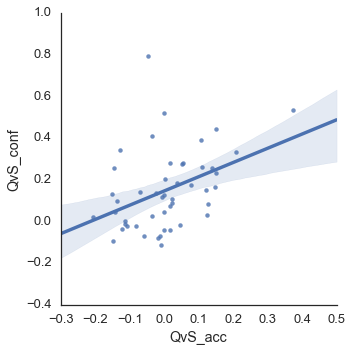

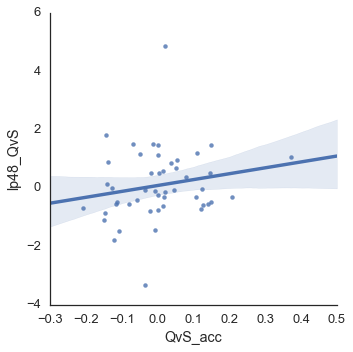

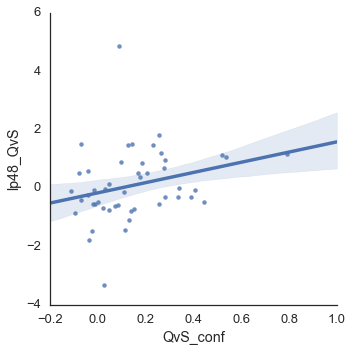

In [167]:
# This makes sense . . . accuracy and confidence are correlated, so the ERPs show a similar relationship to both
sns.lmplot(x='QvS_acc', y='QvS_conf', data=indiffs, fit_reg=True)
sns.lmplot(x='QvS_acc', y='lp48_QvS', data=indiffs, fit_reg=True)
sns.lmplot(x='QvS_conf', y='lp48_QvS', data=indiffs, fit_reg=True)

In [168]:
%%R

r.jk <- .1845 # Correlation (lp48_QvS, QvS_acc)
r.jh <- .2739489  # Correlation (lp48_QvS, QvS_conf)
r.kh <- .4245962 # Correlation (QvS_acc, QvS_conf)
n <- 48 # Size of the group
cocor.dep.groups.overlap(r.jk, r.jh, r.kh, n, var.labels=c("lp48_QvS", "QvS_acc","QvS_conf")) # Not different


  Results of a comparison of two overlapping correlations based on dependent groups

Comparison between r.jk (lp48_QvS, QvS_acc) = 0.1845 and r.jh (lp48_QvS, QvS_conf) = 0.2739
Difference: r.jk - r.jh = -0.0894
Related correlation: r.kh = 0.4246
Data: j = lp48_QvS, k = QvS_acc, h = QvS_conf
Group size: n = 48
Null hypothesis: r.jk is equal to r.jh
Alternative hypothesis: r.jk is not equal to r.jh (two-sided)
Alpha: 0.05

pearson1898: Pearson and Filon's z (1898)
  z = -0.5997, p-value = 0.5487
  Null hypothesis retained

hotelling1940: Hotelling's t (1940)
  t = -0.5834, df = 45, p-value = 0.5625
  Null hypothesis retained

williams1959: Williams' t (1959)
  t = -0.5815, df = 45, p-value = 0.5638
  Null hypothesis retained

olkin1967: Olkin's z (1967)
  z = -0.5997, p-value = 0.5487
  Null hypothesis retained

dunn1969: Dunn and Clark's z (1969)
  z = -0.5802, p-value = 0.5618
  Null hypothesis retained

hendrickson1970: Hendrickson, Stanley, and Hills' (1970) modification of Williams

In [169]:
# Now correlations, across both groups, between:
# (a) Question, Side, and Q-S acuracy and 800-1400 left parietal ERPs;
# (b) Question, Side, and Q-S acuracy and 800-1400 left parietal ERPs.

%Rpush indiffs

%R print(cor.test(indiffs$Q_acc,indiffs$lp814_Question)) # No correl
%R print(cor.test(indiffs$S_acc,indiffs$lp814_Side)) # No correl
%R print(cor.test(indiffs$QvS_acc,indiffs$lp814_QvS)) # Weak correl (p = 0.05)

%R print(cor.test(indiffs$Q_conf,indiffs$lp814_Question)) # No correl
%R print(cor.test(indiffs$S_conf,indiffs$lp814_Side)) # No correl
%R print(cor.test(indiffs$QvS_conf,indiffs$lp814_QvS)) # Weak correl (p = 0.05)


	Pearson's product-moment correlation

data:  indiffs$Q_acc and indiffs$lp814_Question
t = 0.53413, df = 46, p-value = 0.5958
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2103155  0.3547323
sample estimates:
      cor 
0.0785108 




	Pearson's product-moment correlation

data:  indiffs$S_acc and indiffs$lp814_Side
t = 0.54942, df = 46, p-value = 0.5854
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2081680  0.3566939
sample estimates:
      cor 
0.0807424 




	Pearson's product-moment correlation

data:  indiffs$QvS_acc and indiffs$lp814_QvS
t = 2.0416, df = 46, p-value = 0.04695
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.004477093 0.529050357
sample estimates:
      cor 
0.2882451 




	Pearson's product-moment correlation

data:  indiffs$Q_conf and indiffs$lp814_Question
t = -0.43871, df = 46, p-value = 0.6629
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3424043  0.2236878
sample estimates:
        cor 
-0.06454951 




	Pearson's product-moment correlation

data:  indiffs$S_conf and indiffs$lp814_Side
t = 0.039357, df = 46, p-value = 0.9688
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2787916  0.2894602
sample estimates:
        cor 
0.005802716 




	Pearson's product-moment correlation

data:  indiffs$QvS_conf and indiffs$lp814_QvS
t = 2.0111, df = 46, p-value = 0.05019
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.0001701974 0.5259418515
sample estimates:
      cor 
0.2842911 



In [170]:
# Okay, now let's run correlations with accuracy in the MDD group alone
# Interesting: significant effects for MASQ-GDA and MASQ-AA, not expected but in line with a reviewer's suggestion

%Rpush indiffs_dep
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$BDI_total))
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$RSQ_Brood))
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$MASQ_GDA))
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$MASQ_AA))
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$MASQ_AD))
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$PSQI_Total))


	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$BDI_total
t = -1.6088, df = 22, p-value = 0.1219
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.64360967  0.09083556
sample estimates:
       cor 
-0.3244499 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$RSQ_Brood
t = 0.84908, df = 22, p-value = 0.405
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2427080  0.5425405
sample estimates:
      cor 
0.1781289 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$MASQ_GDA
t = -2.1467, df = 22, p-value = 0.0431
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.70175404 -0.01534852
sample estimates:
       cor 
-0.4161685 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$MASQ_AA
t = -2.5978, df = 22, p-value = 0.01643
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.7427334 -0.1008065
sample estimates:
      cor 
-0.484501 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$MASQ_AD
t = 0.79977, df = 22, p-value = 0.4324
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2524272  0.5351932
sample estimates:
      cor 
0.1680854 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$PSQI_Total
t = -0.67773, df = 21, p-value = 0.5053
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5267382  0.2829653
sample estimates:
       cor 
-0.1463013 



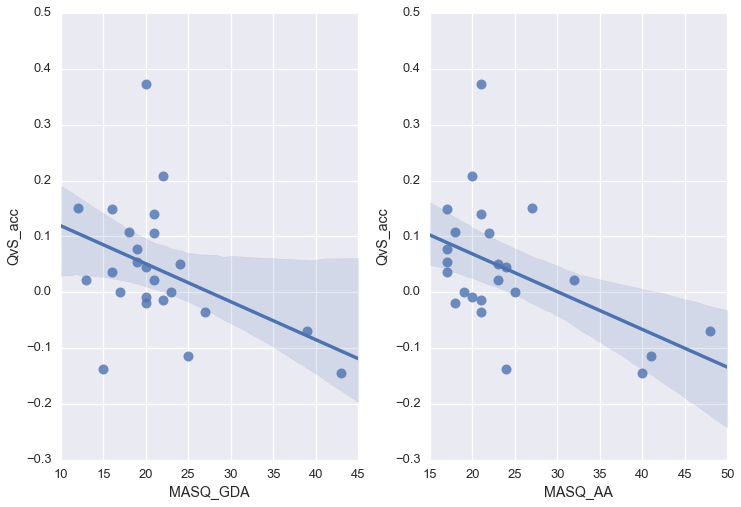

In [171]:
sns.set_style('darkgrid')
fig = plt.figure()
fig.add_subplot(121)
sns.regplot(y='QvS_acc',x='MASQ_GDA',data=indiffs_dep,scatter_kws={"s": 100})
fig.add_subplot(122)
sns.regplot(y='QvS_acc',x='MASQ_AA',data=indiffs_dep,scatter_kws={"s": 100})
fig.tight_layout()
plt.savefig('/Users/danieldillon/Work/Expts/SOURCE/Manuscript/source-mem-paper/Figures/Components/' +
            'MDD_AccAnxiety.pdf')

In [172]:
# Do those anxiety effects hold over BDI? MASQ-GDA does not . . . 
%R mod.1 <- lm(QvS_acc ~ BDI_total, data=indiffs_dep)
%R mod.2 <- lm(QvS_acc ~ BDI_total + MASQ_GDA, data=indiffs_dep)
%R aov <- anova(mod.1,mod.2)
%R print(aov)
# %R print(summary(mod.1))
%R print(summary(mod.2))

Analysis of Variance Table

Model 1: QvS_acc ~ BDI_total
Model 2: QvS_acc ~ BDI_total + MASQ_GDA
  Res.Df     RSS Df Sum of Sq      F Pr(>F)
1     22 0.27191                           
2     21 0.25050  1  0.021409 1.7948 0.1947



Call:
lm(formula = QvS_acc ~ BDI_total + MASQ_GDA, data = indiffs_dep)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.21765 -0.05315 -0.01404  0.04424  0.33236 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.1933235  0.0770934   2.508   0.0204 *
BDI_total   -0.0009204  0.0036323  -0.253   0.8024  
MASQ_GDA    -0.0060088  0.0044852  -1.340   0.1947  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1092 on 21 degrees of freedom
Multiple R-squared:  0.1757,	Adjusted R-squared:  0.09721 
F-statistic: 2.238 on 2 and 21 DF,  p-value: 0.1315



In [173]:
# How about MASQ-AA? No . . . but it's close . . .
%R mod.3 <- lm(QvS_acc ~ BDI_total, data=indiffs_dep)
%R mod.4 <- lm(QvS_acc ~ BDI_total + MASQ_AA, data=indiffs_dep)
%R aov <- anova(mod.3,mod.4)
%R print(aov)
# %R print(summary(mod.1))
%R print(summary(mod.4))

Analysis of Variance Table

Model 1: QvS_acc ~ BDI_total
Model 2: QvS_acc ~ BDI_total + MASQ_AA
  Res.Df     RSS Df Sum of Sq      F  Pr(>F)  
1     22 0.27191                              
2     21 0.23174  1  0.040171 3.6403 0.07016 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



Call:
lm(formula = QvS_acc ~ BDI_total + MASQ_AA, data = indiffs_dep)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.18056 -0.07703 -0.01327  0.05153  0.29725 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.196945   0.071721   2.746   0.0121 *
BDI_total    0.001027   0.003757   0.273   0.7873  
MASQ_AA     -0.007561   0.003963  -1.908   0.0702 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.105 on 21 degrees of freedom
Multiple R-squared:  0.2375,	Adjusted R-squared:  0.1648 
F-statistic:  3.27 on 2 and 21 DF,  p-value: 0.05805



In [174]:
# How strong correlated are the BDI, MASQ-GDA, and MASQ-AA?
%R print(cor.test(indiffs_dep$BDI_total,indiffs_dep$MASQ_GDA))
%R print(cor.test(indiffs_dep$BDI_total,indiffs_dep$MASQ_AA))
%R print(cor.test(indiffs_dep$MASQ_GDA,indiffs_dep$MASQ_AA))


	Pearson's product-moment correlation

data:  indiffs_dep$BDI_total and indiffs_dep$MASQ_GDA
t = 4.5036, df = 22, p-value = 0.0001763
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4013225 0.8566507
sample estimates:
      cor 
0.6925937 




	Pearson's product-moment correlation

data:  indiffs_dep$BDI_total and indiffs_dep$MASQ_AA
t = 5.1873, df = 22, p-value = 3.351e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4828093 0.8814071
sample estimates:
      cor 
0.7417416 




	Pearson's product-moment correlation

data:  indiffs_dep$MASQ_GDA and indiffs_dep$MASQ_AA
t = 4.818, df = 22, p-value = 8.193e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4404464 0.8688045
sample estimates:
      cor 
0.7165333 



Okay, so now I'm switching to the ERPs that showed Q-S/MI diffs in MDDs considered alone . . . 

In [175]:
def clean_input(fname):
    '''Read in one of the Q-S mean amps files, return a df with mean amps and Subject, Latency as columns.'''
    latency = re.split('bins18[0-9]_',fname)[1]
    latency = latency.split('.txt')[0]
    
    df = pd.read_csv(fname,sep='\t',skipinitialspace=True)
    df['Subject'] = df.ERPset.map(lambda x: x.strip('_ERPs'))
    df = df[['Subject','value']]
    g = df.groupby(['Subject'])['value'].mean()
    df = g.to_frame()
    df.reset_index(inplace=True)
    df.rename(columns={'value':latency},inplace=True)
    return df

In [176]:
%cd /Users/danieldillon/Work/Expts/SOURCE/Analysis/ERPs/MeanAmps/MDD/

/Users/danieldillon/Work/Expts/SOURCE/Analysis/ERPs/MeanAmps/MDD


In [177]:
!ls MDD_Sig*

MDD_SigLeftPar_bins180_1400-2000.txt MDD_SigLeftPar_bins181_1400-2000.txt
MDD_SigLeftPar_bins180_400-800.txt   MDD_SigLeftPar_bins181_400-800.txt
MDD_SigLeftPar_bins180_800-1400.txt  MDD_SigLeftPar_bins181_800-1400.txt


In [178]:
dfs = []
fnames = !ls MDD_SigLeftPar_bins180*
for fname in fnames:
    df = clean_input(fname)
    dfs.append(df)
df = pd.concat(dfs,axis=1)
df = df[['Subject','400-800','800-1400','1400-2000']]
df = df.iloc[:,[0,3,4,5]]
new_cols = ['subject','QvS_400_800','QvS_800_1400','QvS_1400_2000']
df.columns = new_cols
df.head()

,subject,QvS_400_800,QvS_800_1400,QvS_1400_2000
0,SM015,1.342083,2.504034,2.394250
1,SM026,0.598833,0.547379,0.627083
2,SM031,1.185083,1.744655,1.735667
3,SM037,0.490083,0.636000,0.470417
4,SM038,0.498125,3.269138,3.724583


In [179]:
indiffs_dep = pd.merge(indiffs_dep,df,on='subject')

In [180]:
# First check if ERPs are strongly correlated across windows . . . 
# Yes, although 40-800 and 1400-2000 is p = 0.05
%Rpush indiffs_dep
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$QvS_800_1400))
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$QvS_1400_2000))
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$QvS_1400_2000))


	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$QvS_800_1400
t = 7.165, df = 22, p-value = 3.498e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6540090 0.9271462
sample estimates:
     cor 
0.836671 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$QvS_1400_2000
t = 2.0514, df = 22, p-value = 0.05232
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.003208701  0.692211689
sample estimates:
      cor 
0.4007067 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$QvS_1400_2000
t = 4.5646, df = 22, p-value = 0.0001519
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4091452 0.8591220
sample estimates:
      cor 
0.6974323 



In [181]:
# Now check for correlations with accuracy and confidence. None of these correlations is significant.

%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$QvS_400_800))
%R print(cor.test(indiffs_dep$QvS_conf,indiffs_dep$QvS_400_800))

%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$QvS_800_1400))
%R print(cor.test(indiffs_dep$QvS_conf,indiffs_dep$QvS_800_1400))

%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$QvS_1400_2000))
%R print(cor.test(indiffs_dep$QvS_conf,indiffs_dep$QvS_1400_2000))


	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$QvS_400_800
t = -0.061545, df = 22, p-value = 0.9515
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4143242  0.3923530
sample estimates:
        cor 
-0.01312035 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_conf and indiffs_dep$QvS_400_800
t = -0.44786, df = 22, p-value = 0.6586
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4800419  0.3206395
sample estimates:
        cor 
-0.09505165 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$QvS_800_1400
t = 0.97223, df = 22, p-value = 0.3415
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2183050  0.5604732
sample estimates:
      cor 
0.2029655 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_conf and indiffs_dep$QvS_800_1400
t = 0.38761, df = 22, p-value = 0.702
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3320707  0.4701358
sample estimates:
       cor 
0.08235845 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$QvS_1400_2000
t = 2.0023, df = 22, p-value = 0.05773
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.01280756  0.68717854
sample estimates:
      cor 
0.3926176 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_conf and indiffs_dep$QvS_1400_2000
t = 1.2292, df = 22, p-value = 0.232
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1669582  0.5959626
sample estimates:
      cor 
0.2535127 



In [182]:
# Now run correlations with ERP amplitudes from 400-800 ms in the MDD group alone
# Only sig relationship is with PSQI

%Rpush indiffs_dep
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$BDI_total))
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$RSQ_Brood))
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$MASQ_GDA))
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$MASQ_AA))
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$MASQ_AD))
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$PSQI_Total))


	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$BDI_total
t = -1.3023, df = 22, p-value = 0.2063
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6055763  0.1522981
sample estimates:
       cor 
-0.2675351 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$RSQ_Brood
t = 0.43392, df = 22, p-value = 0.6686
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3232911  0.4777621
sample estimates:
       cor 
0.09211929 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$MASQ_GDA
t = -0.75351, df = 22, p-value = 0.4591
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5282146  0.2615140
sample estimates:
       cor 
-0.1586157 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$MASQ_AA
t = -0.45267, df = 22, p-value = 0.6552
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4808274  0.3197230
sample estimates:
        cor 
-0.09606355 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$MASQ_AD
t = -0.18625, df = 22, p-value = 0.854
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4360932  0.3696365
sample estimates:
        cor 
-0.03967632 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$PSQI_Total
t = -2.5374, df = 21, p-value = 0.01916
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.74737971 -0.09022399
sample estimates:
       cor 
-0.4844107 



In [183]:
# Now run correlations with ERP amplitudes from 800-1400 ms in the MDD group alone
# Again, only sig relationship is with PSQI

%Rpush indiffs_dep
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$BDI_total))
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$RSQ_Brood))
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$MASQ_GDA))
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$MASQ_AA))
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$MASQ_AD))
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$PSQI_Total))


	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$BDI_total
t = -1.0676, df = 22, p-value = 0.2973
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5739455  0.1993078
sample estimates:
       cor 
-0.2219323 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$RSQ_Brood
t = 0.2208, df = 22, p-value = 0.8273
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3632644  0.4420349
sample estimates:
       cor 
0.04702311 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$MASQ_GDA
t = -0.67443, df = 22, p-value = 0.5071
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5160917  0.2769730
sample estimates:
       cor 
-0.1423257 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$MASQ_AA
t = -0.73199, df = 22, p-value = 0.4719
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5249389  0.2657314
sample estimates:
       cor 
-0.1541942 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$MASQ_AD
t = -0.41543, df = 22, p-value = 0.6819
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.474726  0.326803
sample estimates:
       cor 
-0.0882245 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$PSQI_Total
t = -2.6292, df = 21, p-value = 0.01568
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.7549821 -0.1075018
sample estimates:
       cor 
-0.4976518 



In [184]:
# Now run correlations with ERP amplitudes from 1400-2000 ms in the MDD group alone

%Rpush indiffs_dep
%R print(cor.test(indiffs_dep$QvS_1400_2000,indiffs_dep$BDI_total))
%R print(cor.test(indiffs_dep$QvS_1400_2000,indiffs_dep$RSQ_Brood))
%R print(cor.test(indiffs_dep$QvS_1400_2000,indiffs_dep$MASQ_GDA))
%R print(cor.test(indiffs_dep$QvS_1400_2000,indiffs_dep$MASQ_AA))
%R print(cor.test(indiffs_dep$QvS_1400_2000,indiffs_dep$MASQ_AD))
%R print(cor.test(indiffs_dep$QvS_1400_2000,indiffs_dep$PSQI_Total))


	Pearson's product-moment correlation

data:  indiffs_dep$QvS_1400_2000 and indiffs_dep$BDI_total
t = 0.044149, df = 22, p-value = 0.9652
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3954861  0.4112475
sample estimates:
        cor 
0.009412264 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_1400_2000 and indiffs_dep$RSQ_Brood
t = -0.054913, df = 22, p-value = 0.9567
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4131524  0.3935485
sample estimates:
        cor 
-0.01170674 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_1400_2000 and indiffs_dep$MASQ_GDA
t = 0.45608, df = 22, p-value = 0.6528
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3190730  0.4813837
sample estimates:
       cor 
0.09678068 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_1400_2000 and indiffs_dep$MASQ_AA
t = -0.58377, df = 22, p-value = 0.5653
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5018989  0.2945645
sample estimates:
       cor 
-0.1235082 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_1400_2000 and indiffs_dep$MASQ_AD
t = -0.0028392, df = 22, p-value = 0.9978
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4039034  0.4028898
sample estimates:
          cor 
-0.0006053295 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_1400_2000 and indiffs_dep$PSQI_Total
t = -0.31993, df = 21, p-value = 0.7522
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4683999  0.3526825
sample estimates:
        cor 
-0.06964437 



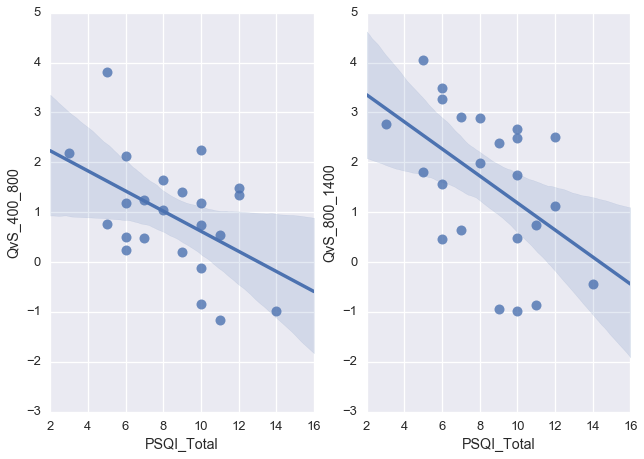

In [185]:
fig = plt.figure()
fig.add_subplot(121)
sns.regplot(y='QvS_400_800',x='PSQI_Total',data=indiffs_dep,scatter_kws={"s": 100})
fig.add_subplot(122)
sns.regplot(y='QvS_800_1400',x='PSQI_Total',data=indiffs_dep,scatter_kws={"s": 100})
plt.savefig('/Users/danieldillon/Work/Expts/SOURCE/Manuscript/source-mem-paper/Figures/Components/' +
            'MDD_ERP_PSQI.pdf')

In [186]:
# Check that PSQI predicts Q-S/mobility ERPs after accounting for BDI. 400-800 ms first . . . 
indiffs_dep_psqi = indiffs_dep.dropna(subset=['PSQI_Total']) # Need to drop the person with no PSQI data
%Rpush indiffs_dep_psqi
%R mod.1 <- lm(QvS_400_800 ~ BDI_total, data=indiffs_dep_psqi)
%R mod.2 <- lm(QvS_400_800 ~ BDI_total + PSQI_Total, data=indiffs_dep_psqi)
%R aov <- anova(mod.1,mod.2)
%R print(aov)
%R print(summary(mod.2))
%R print(lm.beta(mod.2))
%R print(lm.deltaR2(mod.1, mod.2))

Analysis of Variance Table

Model 1: QvS_400_800 ~ BDI_total
Model 2: QvS_400_800 ~ BDI_total + PSQI_Total
  Res.Df    RSS Df Sum of Sq      F  Pr(>F)  
1     21 26.358                              
2     20 21.508  1    4.8499 4.5097 0.04637 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



Call:
lm(formula = QvS_400_800 ~ BDI_total + PSQI_Total, data = indiffs_dep_psqi)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.61491 -0.80612  0.04195  0.59723  2.17522 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  2.80491    0.82075   3.418  0.00273 **
BDI_total   -0.01162    0.02703  -0.430  0.67184   
PSQI_Total  -0.18687    0.08800  -2.124  0.04637 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.037 on 20 degrees of freedom
Multiple R-squared:  0.2417,	Adjusted R-squared:  0.1658 
F-statistic: 3.187 on 2 and 20 DF,  p-value: 0.0629



  BDI_total  PSQI_Total 
-0.09090067 -0.44899513 


SSE (Compact) =  26.35816 
SSE (Augmented) =  21.50831 
Delta R-Squared =  0.1709955 
Partial Eta-Squared (PRE) =  0.1839981 
F(1,20) = 4.509747, p = 0.04636942
$sseC
[1] 26.35816

$sseA
[1] 21.50831

$pC
[1] 2

$pA
[1] 3

$nDF
[1] 1

$dDF
[1] 20

$Fstat
[1] 4.509747

$p
[1] 0.04636942

$PRE
[1] 0.1839981

$DeltaR2
[1] 0.1709955



In [187]:
# Now 800-1400 ms . . . 

%R mod.3 <- lm(QvS_800_1400 ~ BDI_total, data=indiffs_dep_psqi)
%R mod.4 <- lm(QvS_800_1400 ~ BDI_total + PSQI_Total, data=indiffs_dep_psqi)
%R aov <- anova(mod.3,mod.4)
%R print(aov)
%R print(summary(mod.4))
%R print(lm.beta(mod.4))
%R print(lm.deltaR2(mod.3, mod.4))

Analysis of Variance Table

Model 1: QvS_800_1400 ~ BDI_total
Model 2: QvS_800_1400 ~ BDI_total + PSQI_Total
  Res.Df    RSS Df Sum of Sq      F  Pr(>F)  
1     21 46.258                              
2     20 36.514  1    9.7441 5.3372 0.03167 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



Call:
lm(formula = QvS_800_1400 ~ BDI_total + PSQI_Total, data = indiffs_dep_psqi)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4572 -0.7521  0.3723  1.0690  1.8030 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  3.967464   1.069383   3.710  0.00138 **
BDI_total   -0.004882   0.035223  -0.139  0.89116   
PSQI_Total  -0.264877   0.114653  -2.310  0.03167 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.351 on 20 degrees of freedom
Multiple R-squared:  0.2484,	Adjusted R-squared:  0.1732 
F-statistic: 3.305 on 2 and 20 DF,  p-value: 0.05754



  BDI_total  PSQI_Total 
-0.02917201 -0.48628621 


SSE (Compact) =  46.25766 
SSE (Augmented) =  36.51358 
Delta R-Squared =  0.200579 
Partial Eta-Squared (PRE) =  0.210648 
F(1,20) = 5.337238, p = 0.03166714
$sseC
[1] 46.25766

$sseA
[1] 36.51358

$pC
[1] 2

$pA
[1] 3

$nDF
[1] 1

$dDF
[1] 20

$Fstat
[1] 5.337238

$p
[1] 0.03166714

$PRE
[1] 0.210648

$DeltaR2
[1] 0.200579



### Congruency sequence 

The basic question is, can healthy and depressed adults reconfigure set just as easily or no? Let's keep it simple at first, just add a 'cue_1back' column that is either "same" or "different". May ultimately be worthwhile to split this up further to look at switches into or out of an episodic (or conceptual/perceptual) set, but let's start with the basics.

In [188]:
erp_ret.head()

,subject,run,trial,cue,item,condition,response,RT,iti_dur(ms),RT_ms,...,PSQI_DayDys,PSQI_Efficiency,PSQI_Quality,PSQI_Medication,PSQI_Total,WTAR_NatEng,WTAR_StdScore,guess,encoding_location,encoding_task
0,SM011,1,1,Question,cabin,3,1,4.669,1002,4669,...,0,0,0,0,1,yes,89,0,left,mobility
1,SM011,1,2,Question,desk,4,1,3.201,501,3201,...,0,0,0,0,1,yes,89,0,right,mobility
2,SM011,1,3,Question,fern,1,1,0.784,501,784,...,0,0,0,0,1,yes,89,0,left,animacy
3,SM011,1,4,Odd_even,ninety-three,5,1,1.501,501,1501,...,0,0,0,0,1,yes,89,0,none,none
4,SM011,1,5,Question,balloon,2,1,1.067,1002,1067,...,0,0,0,0,1,yes,89,0,right,animacy


In [189]:
dfs = []
for sub in erp_ret.subject.unique():
    df = erp_ret[erp_ret.subject == sub]
    df['cue_1b'] = df.cue.shift(1)
    dfs.append(df)
erp_ret = pd.concat(dfs)
erp_ret[['cue','cue_1b']].head()

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,cue,cue_1b
0,Question,NaN
1,Question,Question
2,Question,Question
3,Odd_even,Question
4,Question,Odd_even


In [190]:
def AddSetSwitch(data):
    '''If cue on current trial and trial 1back are same, no switch, otherwise switch.'''
    cue, cue_1b = data
    if pd.isnull(cue) or pd.isnull(cue_1b):
        switch = np.nan
    elif cue == cue_1b:
        switch = 'no'
    else:
        switch = 'yes'
    
    return switch

In [191]:
erp_ret['switch'] = erp_ret[['cue','cue_1b']].apply(AddSetSwitch,axis=1)

In [192]:
erp_ret[['cue','cue_1b','switch']].head()

,cue,cue_1b,switch
0,Question,NaN,NaN
1,Question,Question,no
2,Question,Question,no
3,Odd_even,Question,yes
4,Question,Odd_even,yes


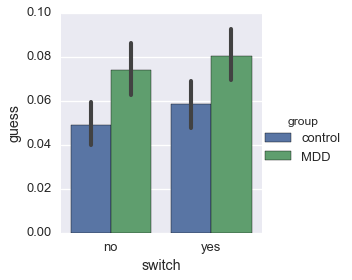

In [193]:
# First question: is guessing affected by switching? Looks like you might have a Group x Switch interaction there.
sns.factorplot(y='guess',x='switch',hue='group',units='subject',ci=68,kind='bar',
               data=erp_ret)

In [194]:
# This shows a trend for a group difference in guessing, but neither the switch effect nor the GxS is sig.
erp_switch = erp_ret[(erp_ret.switch == 'no') | (erp_ret.switch == 'yes')]

%Rpush erp_switch
# %R str(erp_switch)

%R guess.sw <- aov_ez(dv='guess',id='subject',within='switch',between='group',data=erp_switch)
%R print(guess.sw)

Anova Table (Type 3 tests)

Response: guess
        Effect    df  MSE    F    ges p.value
1        group 1, 46 0.00 2.64    .05     .11
2       switch 1, 46 0.00 2.14   .004     .15
3 group:switch 1, 46 0.00 0.00 <.0001    >.99

Sphericity correction method: GG 


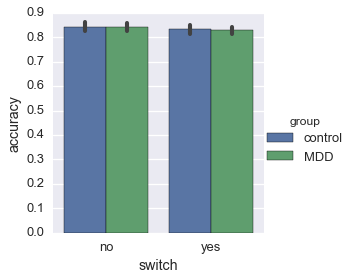

In [195]:
# How about accuracy once guesses are removed? Maybe a tiny negative effect . . . 
sns.factorplot(y='accuracy',x='switch',hue='group',units='subject',ci=68,kind='bar',
               data=erp_switch[~(erp_switch.response == 3)])

In [196]:
# Trend for effect of switch on accuracy (p = 0.06, no > yes)
erp_switch_nog = erp_switch[~(erp_switch.response == 3)]
%Rpush erp_switch_nog

%R switch_acc <- aov_ez(dv='accuracy',id='subject',within='switch',between='group',data=erp_switch_nog)

%R print(switch_acc)               

Anova Table (Type 3 tests)

Response: accuracy
        Effect    df  MSE    F    ges p.value
1        group 1, 46 0.01 0.01  .0002     .92
2       switch 1, 46 0.00 2.03   .005     .16
3 group:switch 1, 46 0.00 0.00 <.0001     .99

Sphericity correction method: GG 


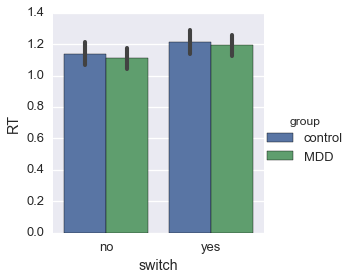

In [197]:
# How about RT? Looks like a slow-down
sns.factorplot(y='RT',x='switch',hue='group',units='subject',ci=68,kind='bar',
               data=erp_switch_nog)

In [198]:
# Strong effect of switching on RT
%R switch_rt <- aov_ez(dv='RT',id='subject',within='switch',between='group',data=erp_switch_nog)

%R print(switch_rt)               

Anova Table (Type 3 tests)

Response: RT
        Effect    df  MSE         F   ges p.value
1        group 1, 44 0.22      0.07  .001     .80
2       switch 1, 44 0.01 25.49 ***   .02  <.0001
3 group:switch 1, 44 0.01      0.55 .0004     .46

Sphericity correction method: GG 


In [199]:
erp_switch_nog.confidence.unique()

array(['high', 'low'], dtype=object)

In [200]:
erp_switch_nog['high_confidence'] = erp_switch_nog.confidence.apply(lambda x: 1 if x == 'high' else 0)

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


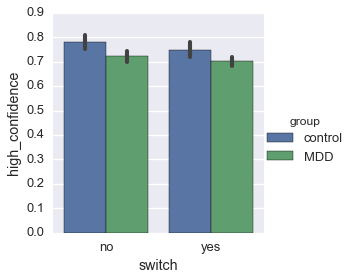

In [201]:
# How about confidence? doesn't look like much of an effect there . . . 
sns.factorplot(y='high_confidence',x='switch',hue='group',units='subject',ci=68,kind='bar',
               data=erp_switch_nog)

In [202]:
# There is a reliable effect of switching on confidence . . . 
%Rpush erp_switch_nog

%R switch_conf <- aov_ez(dv='high_confidence',id='subject',within='switch',between='group',data=erp_switch_nog)

%R print(switch_conf)     

Anova Table (Type 3 tests)

Response: high_confidence
        Effect    df  MSE      F   ges p.value
1        group 1, 46 0.03   2.23   .04     .14
2       switch 1, 46 0.00 6.26 *  .007     .02
3 group:switch 1, 46 0.00   0.26 .0003     .61

Sphericity correction method: GG 


### Additional responses to reviewers . . .  

In [203]:
df.accuracy.dtype

dtype('float64')

'data.frame':	96 obs. of  4 variables:
 $ subject        : Factor w/ 48 levels "SM011","SM013",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ group          : Factor w/ 2 levels "control","MDD": 1 1 1 1 1 1 2 2 1 1 ...
 $ accuracy       : num  0 1 0 1 0 1 0 1 0 1 ...
 $ high_confidence: num  0.782 0.809 0.571 0.722 0.182 ...


Anova Table (Type 3 tests)

Response: high_confidence
          Effect    df  MSE          F   ges p.value
1          group 1, 46 0.08       1.17   .02     .28
2       accuracy 1, 46 0.01 152.23 ***   .31  <.0001
3 group:accuracy 1, 46 0.01       0.05 .0001     .83

Sphericity correction method: GG 


accuracy
0    35.709083
1    63.717114
Name: high_confidence, dtype: float64
accuracy
0    24.209307
1    18.284271
Name: high_confidence, dtype: float64


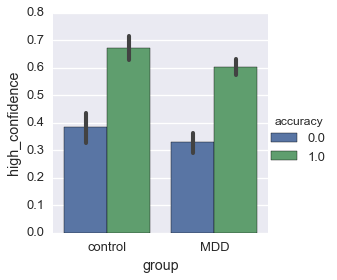

In [204]:
# Is there a bigger confidence difference for hits vs. misses in controls vs. MDD?
g = noe_nog.groupby(['subject','group','accuracy'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

sns.factorplot(y='high_confidence',x='group',hue='accuracy',units='subject',ci=68,kind='bar',data=df)

%Rpush df
# %R df$accuracy <- as.factor(df$accuracy)
%R str(df)
%R AccConf.aov <- aov_ez(dv='high_confidence',id='subject',within=c('accuracy'),between=c('group'),data=df)
%R print(AccConf.aov)

print 100*df.groupby('accuracy')['high_confidence'].mean()
print 100*df.groupby('accuracy')['high_confidence'].std()

In [205]:
# Are hit rates and RTs related?
g = noe_nog.groupby(['subject','group','cue','encoding_task','accuracy'])['RT'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
g = df.groupby(['group','cue','encoding_task','accuracy'])['RT'].mean()

%Rpush df
%R accRT.aov <- aov_ez(dv='RT',id='subject',within=c('cue','encoding_task','accuracy'),between='group',data=df)
%R print(accRT.aov)

Anova Table (Type 3 tests)

Response: RT
                             Effect    df  MSE          F    ges p.value
1                             group 1, 43 1.58       0.06  .0010     .80
2                               cue 1, 43 0.31 170.22 ***    .35  <.0001
3                         group:cue 1, 43 0.31       0.15  .0005     .70
4                     encoding_task 1, 43 0.05       0.40  .0002     .53
5               group:encoding_task 1, 43 0.05       0.00 <.0001    >.99
6                          accuracy 1, 43 0.10  62.53 ***    .06  <.0001
7                    group:accuracy 1, 43 0.10       1.97   .002     .17
8                 cue:encoding_task 1, 43 0.03       0.46  .0001     .50
9           group:cue:encoding_task 1, 43 0.03       0.41  .0001     .52
10                     cue:accuracy 1, 43 0.10       2.09   .002     .16
11               group:cue:accuracy 1, 43 0.10       0.34  .0004     .56
12           encoding_task:accuracy 1, 43 0.07     5.37 *   .004     .03
13     gro

#### Checking on effect sizes for Table 1 

In [206]:
# Gender breakdown. Note that the chi-square result is different than what I have in the paper because R is applying
# the Yates correction, and no matter what I try I cannot get it to stop. I have verified that if I turn the correction
# on for the sp.stats chi-square I ran before, I get the same result. Since I'm only re-running this to get the ES,
# I don't think it's a real problem (since that should not be affected by the correction).
g = erp_enc.groupby(['subject','group'])['Gender'].value_counts()
df = g.to_frame()
df.reset_index(inplace=True)
del df[0]

g = df.groupby('group')['Gender'].value_counts()
df = g.to_frame()
df.reset_index(inplace=True)
df.rename(columns={0:'value','Gender':'gender'},inplace=True)
print df.head()

%Rpush df
%R row1 = c(15,13)
%R row2 = c(9,11)
%R data.table = rbind(row1,row2)
%R print(chisq.test(data.table), correct = FALSE)
%R print(assocstats(data.table))

     group gender  value
0      MDD      f     15
1      MDD      m      9
2  control      f     13
3  control      m     11



	Pearson's Chi-squared test with Yates' continuity correction

data:  data.table
X-squared = 0.085714, df = 1, p-value = 0.7697



                     X^2 df P(> X^2)
Likelihood Ratio 0.34331  1  0.55792
Pearson          0.34286  1  0.55818

Phi-Coefficient   : 0.085 
Contingency Coeff.: 0.084 
Cramer's V        : 0.085 


In [207]:
erp_enc.columns

Index([        u'subject',             u'run',           u'trial',
                  u'word',            u'type',       u'condition',
                  u'side',            u'task',        u'response',
                    u'RT',     u'iti_dur(ms)',           u'RT_ms',
                  u'lnRT',         u'outlier',           u'group',
                   u'Age',          u'Gender',            u'Race',
             u'Ethnicity',  u'Marital_Status', u'Education_Level',
       u'Education_Years',      u'Occupation',  u'Highest Degree',
                u'Income',       u'Inclusion',       u'BDI_total',
              u'MASQ_GDA',         u'MASQ_AA',        u'MASQ_GDD',
               u'MASQ_AD',         u'RSQ_Dep',       u'RSQ_Brood',
           u'RSQ_Reflect',   u'PSQI_Duration',    u'PSQI_Disturb',
          u'PSQI_Latency',     u'PSQI_DayDys', u'PSQI_Efficiency',
          u'PSQI_Quality', u'PSQI_Medication',      u'PSQI_Total',
           u'WTAR_NatEng',   u'WTAR_StdScore',        u'accura

In [208]:
df = erp_enc.groupby(['subject','group'])[['Age','Education_Years','BDI_total','MASQ_GDA','MASQ_AA','MASQ_GDD','MASQ_AD',
                              'RSQ_Dep','RSQ_Brood','RSQ_Reflect','PSQI_Total','WTAR_StdScore']].mean()
df.reset_index(inplace=True)
df.head()

%Rpush df
# %R str(df)

%R print(t.test(Age ~ group, data=df))
%R print(cohen.d(Age ~ group, data=df, paired=FALSE))

%R print(t.test(Education_Years ~ group, data=df))
%R print(cohen.d(Education_Years ~ group, data=df, paired=FALSE))

%R print(t.test(BDI_total ~ group, data=df))
%R print(cohen.d(BDI_total ~ group, data=df, paired=FALSE))

%R print(t.test(MASQ_GDA ~ group, data=df))
%R print(cohen.d(MASQ_GDA ~ group, data=df, paired=FALSE))

%R print(t.test(MASQ_AA ~ group, data=df))
%R print(cohen.d(MASQ_AA ~ group, data=df, paired=FALSE))

%R print(t.test(MASQ_GDD ~ group, data=df))
%R print(cohen.d(MASQ_GDD ~ group, data=df, paired=FALSE))

%R print(t.test(MASQ_AD ~ group, data=df))
%R print(cohen.d(MASQ_AD ~ group, data=df, paired=FALSE))

%R print(t.test(RSQ_Dep ~ group, data=df))
%R print(cohen.d(RSQ_Dep ~ group, data=df, paired=FALSE))

%R print(t.test(RSQ_Brood ~ group, data=df))
%R print(cohen.d(RSQ_Brood ~ group, data=df, paired=FALSE))

%R print(t.test(RSQ_Reflect ~ group, data=df))
%R print(cohen.d(RSQ_Reflect ~ group, data=df, paired=FALSE))

%R print(t.test(PSQI_Total ~ group, data=df))
%R print(cohen.d(PSQI_Total ~ group, data=df, paired=FALSE))

%R print(t.test(WTAR_StdScore ~ group, data=df))
%R print(cohen.d(WTAR_StdScore ~ group, data=df, paired=FALSE))


	Welch Two Sample t-test

data:  Age by group
t = 0.24737, df = 45.916, p-value = 0.8057
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -5.650665  7.233998
sample estimates:
mean in group control     mean in group MDD 
             30.58333              29.79167 




Cohen's d

d estimate: 0.07140874 (negligible)
95 percent confidence interval:
       inf        sup 
-0.5223592  0.6651766 



	Welch Two Sample t-test

data:  Education_Years by group
t = 0.95426, df = 44.102, p-value = 0.3452
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6948957  1.9448957
sample estimates:
mean in group control     mean in group MDD 
             16.91667              16.29167 




Cohen's d

d estimate: 0.2754709 (small)
95 percent confidence interval:
       inf        sup 
-0.3210300  0.8719718 



	Welch Two Sample t-test

data:  BDI_total by group
t = -13.153, df = 25.978, p-value = 5.414e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -27.84713 -20.31953
sample estimates:
mean in group control     mean in group MDD 
             1.291667             25.375000 




Cohen's d

d estimate: -3.797005 (large)
95 percent confidence interval:
      inf       sup 
-4.804417 -2.789593 



	Welch Two Sample t-test

data:  MASQ_GDA by group
t = -5.5468, df = 27.222, p-value = 6.849e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -11.412295  -5.250749
sample estimates:
mean in group control     mean in group MDD 
             13.04348              21.37500 




Cohen's d

d estimate: -1.589349 (large)
95 percent confidence interval:
       inf        sup 
-2.2819297 -0.8967679 



	Welch Two Sample t-test

data:  MASQ_AA by group
t = -3.7459, df = 23.681, p-value = 0.001016
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -9.847785 -2.847867
sample estimates:
mean in group control     mean in group MDD 
             17.65217              24.00000 




Cohen's d

d estimate: -1.07019 (large)
95 percent confidence interval:
       inf        sup 
-1.7141378 -0.4262428 



	Welch Two Sample t-test

data:  MASQ_GDD by group
t = -11.892, df = 25.073, p-value = 8.381e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -29.10160 -20.51072
sample estimates:
mean in group control     mean in group MDD 
             13.65217              38.45833 




Cohen's d

d estimate: -3.401563 (large)
95 percent confidence interval:
      inf       sup 
-4.353119 -2.450007 



	Welch Two Sample t-test

data:  MASQ_AD by group
t = -13.107, df = 39.601, p-value = 5.498e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -47.24668 -34.61926
sample estimates:
mean in group control     mean in group MDD 
             45.60870              86.54167 




Cohen's d

d estimate: -3.852 (large)
95 percent confidence interval:
      inf       sup 
-4.881209 -2.822791 



	Welch Two Sample t-test

data:  RSQ_Dep by group
t = -11.247, df = 45.89, p-value = 8.805e-15
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -17.68483 -12.31517
sample estimates:
mean in group control     mean in group MDD 
             17.95833              32.95833 




Cohen's d

d estimate: -3.24663 (large)
95 percent confidence interval:
      inf       sup 
-4.161358 -2.331903 



	Welch Two Sample t-test

data:  RSQ_Brood by group
t = -6.1375, df = 43.797, p-value = 2.155e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -6.365313 -3.218020
sample estimates:
mean in group control     mean in group MDD 
              7.75000              12.54167 




Cohen's d

d estimate: -1.77174 (large)
95 percent confidence interval:
      inf       sup 
-2.476426 -1.067053 



	Welch Two Sample t-test

data:  RSQ_Reflect by group
t = -3.2575, df = 43.422, p-value = 0.002185
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -5.194020 -1.222647
sample estimates:
mean in group control     mean in group MDD 
             9.041667             12.250000 




Cohen's d

d estimate: -0.9403631 (large)
95 percent confidence interval:
       inf        sup 
-1.5672312 -0.3134949 



	Welch Two Sample t-test

data:  PSQI_Total by group
t = -7.824, df = 40.278, p-value = 1.309e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -6.893087 -4.063434
sample estimates:
mean in group control     mean in group MDD 
             3.000000              8.478261 




Cohen's d

d estimate: -2.298002 (large)
95 percent confidence interval:
      inf       sup 
-3.078613 -1.517390 



	Welch Two Sample t-test

data:  WTAR_StdScore by group
t = 0.25091, df = 41.574, p-value = 0.8031
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -4.990584  6.407251
sample estimates:
mean in group control     mean in group MDD 
             117.1667              116.4583 




Cohen's d

d estimate: 0.07243112 (negligible)
95 percent confidence interval:
       inf        sup 
-0.5213425  0.6662047 


The most vexed issue in this experiment, behaviorally at least, is whether the dependency of Question accuracy on encoding task reflects a true effect of memory accuracy or is instead due to response bias. I do not think there is a way to address that issue while retaining the ability to look at Cue x Task interactions. However, Starns & Hicks (2016) follow themselves in 2013 and Slotnick & Dodson (2005) in computing source d' scores. For us to do that, HR would be p('MI'|MI) and p('right'|right), and FAR would be p('MI'|LNL) and p('right'|left). You can immediately see that we can't look at the effects of tasks separately under the Question cue here b/c both tasks are in the d' calculation. But it may be worth computing these metrics to be able to say whether or not you see a bias in MDD vs. HC. To compute this you will need the number of hits, misses, FAs, and CRs . . .  

In [209]:
noe_nog.head()

,subject,run,trial,cue,item,condition,response,RT,iti_dur(ms),RT_ms,...,PSQI_Efficiency,PSQI_Quality,PSQI_Medication,PSQI_Total,WTAR_NatEng,WTAR_StdScore,guess,encoding_location,encoding_task,high_confidence
0,SM011,1,1,Question,cabin,3,1,4.669,1002,4669,...,0,0,0,1,yes,89,0,left,mobility,1
1,SM011,1,2,Question,desk,4,1,3.201,501,3201,...,0,0,0,1,yes,89,0,right,mobility,1
2,SM011,1,3,Question,fern,1,1,0.784,501,784,...,0,0,0,1,yes,89,0,left,animacy,1
3,SM011,1,5,Question,balloon,2,1,1.067,1002,1067,...,0,0,0,1,yes,89,0,right,animacy,1
4,SM011,1,7,Question,pine,4,1,0.567,2004,567,...,0,0,0,1,yes,89,0,right,mobility,1


In [210]:
# First give me a df with d' data under the Question cue
qd = {}
sd = {}
ct = 0
for sub in noe_nog.subject.unique():
    sdf = noe_nog[noe_nog.subject == sub]
    group = sdf.group.unique()[0]
    
    # Question
    nHits = len(sdf[(sdf.cue == 'Question') & (sdf.encoding_task == 'mobility') & (sdf.accuracy == 1)])
    nMisses = len(sdf[(sdf.cue == 'Question') & (sdf.encoding_task == 'mobility') & (sdf.accuracy == 0)])
    nFAs = len(sdf[(sdf.cue == 'Question') & (sdf.encoding_task == 'animacy') & (sdf.accuracy == 0)])
    nCRs = len(sdf[(sdf.cue == 'Question') & (sdf.encoding_task == 'animacy') & (sdf.accuracy == 1)])
    Q_sdt = misc.sdt_calc([nHits,nMisses,nFAs,nCRs])
    qd[ct] = {'subject':sub,'group':group,'cue':'Question','HR':Q_sdt['HR'],'FAR':Q_sdt['FAR'],
              'dprime':Q_sdt['dprime'],'c':Q_sdt['c']}
    
    # Side
    nHits = len(sdf[(sdf.cue == 'Side') & (sdf.encoding_location == 'right') & (sdf.accuracy == 1)])
    nMisses = len(sdf[(sdf.cue == 'Side') & (sdf.encoding_location == 'right') & (sdf.accuracy == 0)])
    nFAs = len(sdf[(sdf.cue == 'Side') & (sdf.encoding_location == 'left') & (sdf.accuracy == 0)])
    nCRs = len(sdf[(sdf.cue == 'Side') & (sdf.encoding_location == 'left') & (sdf.accuracy == 1)])
    S_sdt = misc.sdt_calc([nHits,nMisses,nFAs,nCRs])
    sd[ct] = {'subject':sub,'group':group,'cue':'Side','HR':S_sdt['HR'],'FAR':S_sdt['FAR'],
              'dprime':S_sdt['dprime'],'c':S_sdt['c']}
      
    ct = ct + 1

qdf = pd.DataFrame.from_dict(qd,orient='index')
sdf = pd.DataFrame.from_dict(sd,orient='index')
df = pd.concat([qdf,sdf])
df = df[['subject','group','cue','HR','FAR','dprime','c']]
df.reset_index(inplace=True,drop=True)
df.head()

,subject,group,cue,HR,FAR,dprime,c
0,SM011,control,Question,0.297872,0.291667,0.017993,0.539526
1,SM013,control,Question,0.717391,0.523810,0.515392,-0.317413
2,SM014,control,Question,0.727273,0.276596,1.197570,-0.005800
3,SM017,control,Question,0.854167,0.340426,1.465775,-0.321585
4,SM018,control,Question,0.833333,0.212766,1.764282,-0.085280


In [211]:
df.groupby(['group','cue'])['dprime'].mean()

group    cue     
MDD      Question    1.357124
         Side        1.504419
control  Question    1.285229
         Side        1.848270
Name: dprime, dtype: float64

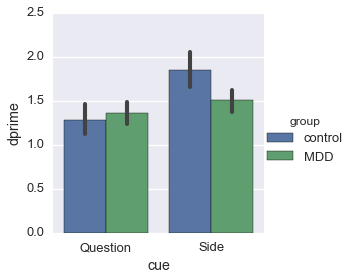

In [212]:
sns.factorplot(y='dprime',x='cue',hue='group',units='subject',kind='bar',ci=68,data=df)

In [213]:
%Rpush df
%R str(df)

'data.frame':	96 obs. of  7 variables:
 $ subject: Factor w/ 48 levels "SM011","SM013",..: 1 2 3 5 6 7 8 9 10 11 ...
 $ group  : Factor w/ 2 levels "control","MDD": 1 1 1 1 1 1 1 1 1 1 ...
 $ cue    : Factor w/ 2 levels "Question","Side": 1 1 1 1 1 1 1 1 1 1 ...
 $ HR     : num  0.298 0.717 0.727 0.854 0.833 ...
 $ FAR    : num  0.292 0.524 0.277 0.34 0.213 ...
 $ dprime : num  0.018 0.515 1.198 1.466 1.764 ...
 $ c      : num  0.5395 -0.3174 -0.0058 -0.3216 -0.0853 ...


In [214]:
# Group x Cue interaction is significant
%R dprime.aov <- aov_ez(dv='dprime',id='subject',within='cue',between='group',data=df)
%R print(dprime.aov)

# No group differences under Question or Side, but the pattern is the same as for accuracy
%R question = subset(df, cue == 'Question')
%R dprime.q <- t.test(question$dprime ~ question$group)
%R print(dprime.q)

%R side = subset(df, cue == 'Side')
%R dprime.s <- t.test(side$dprime ~ side$group)
%R print(dprime.s)

# In controls, there is a strong Q < S difference, but this is not significant for MDD 
%R hc = subset(df, group == 'control')
%R dprime.hc <- t.test(hc$dprime ~ hc$cue, paired=TRUE)
%R print(dprime.hc)

%R mdd = subset(df, group == 'MDD')
%R dprime.mdd <- t.test(mdd$dprime ~ mdd$cue, paired=TRUE)
%R print(dprime.mdd)

Anova Table (Type 3 tests)

Response: dprime
     Effect    df  MSE         F  ges p.value
1     group 1, 46 1.12      0.40 .007     .53
2       cue 1, 46 0.16 18.51 ***  .05  <.0001
3 group:cue 1, 46 0.16    6.34 *  .02     .02

Sphericity correction method: GG 



	Welch Two Sample t-test

data:  question$dprime by question$group
t = -0.32695, df = 41.521, p-value = 0.7453
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.5158097  0.3720202
sample estimates:
mean in group control     mean in group MDD 
             1.285229              1.357124 




	Welch Two Sample t-test

data:  side$dprime by side$group
t = 1.4229, df = 38.428, p-value = 0.1628
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1451732  0.8328747
sample estimates:
mean in group control     mean in group MDD 
             1.848270              1.504419 




	Paired t-test

data:  hc$dprime by hc$cue
t = -4.1795, df = 23, p-value = 0.00036
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.8417215 -0.2843604
sample estimates:
mean of the differences 
              -0.563041 




	Paired t-test

data:  mdd$dprime by mdd$cue
t = -1.5429, df = 23, p-value = 0.1365
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.34478405  0.05019308
sample estimates:
mean of the differences 
             -0.1472955 

